In [102]:
%matplotlib inline
%run notebook_setup.py

<Figure size 640x480 with 0 Axes>

In [103]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
from corner import corner
import lightkurve as lk

starry.config.quiet = True

## HR7495 Known Proprierties

In [104]:
## Things we'll assume are known (HR7495)
inc = 21.0 # Inclination
P = 1.447  # d (spike period)
vrot = 113 # km/s
Rstar = 3.3 # Rsun
Aspike = 173.3 # ppm

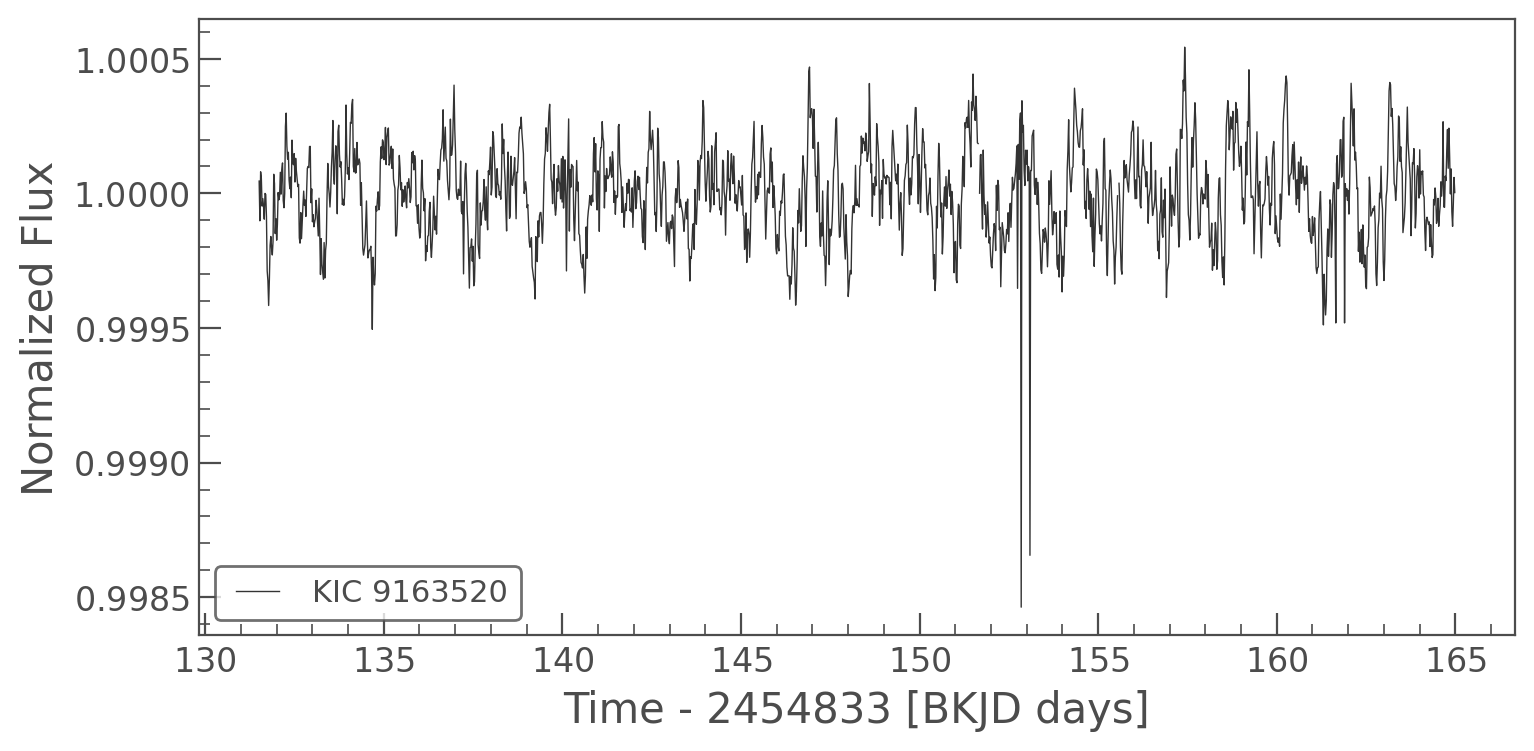

In [105]:
# Search Kepler data for Quarters 6, 7, and 8.
search_result = lk.search_lightcurve('KIC 9163520', author='Kepler', quarter=(1, 2, 3,4,5,6,7,8,9,10))
# Download and stitch the data together
lc = search_result.download_all().stitch()
# Plot the resulting light curve
lc.plot();

<Quantity 1.47349469 d>

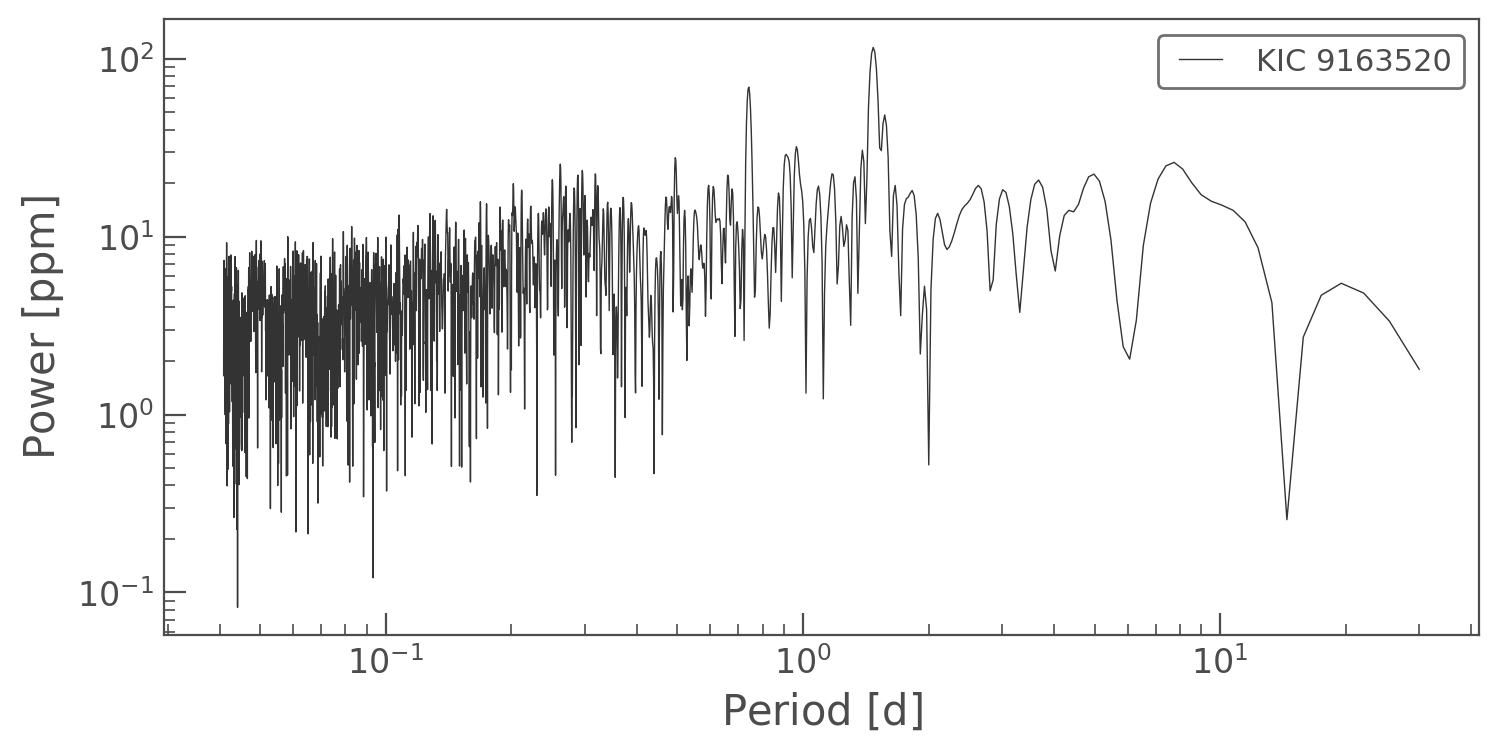

In [106]:
#pg = lc.to_periodogram(maximum_period=100)
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=30)
pg.plot(view='period',scale='log');
pg.period_at_max_power


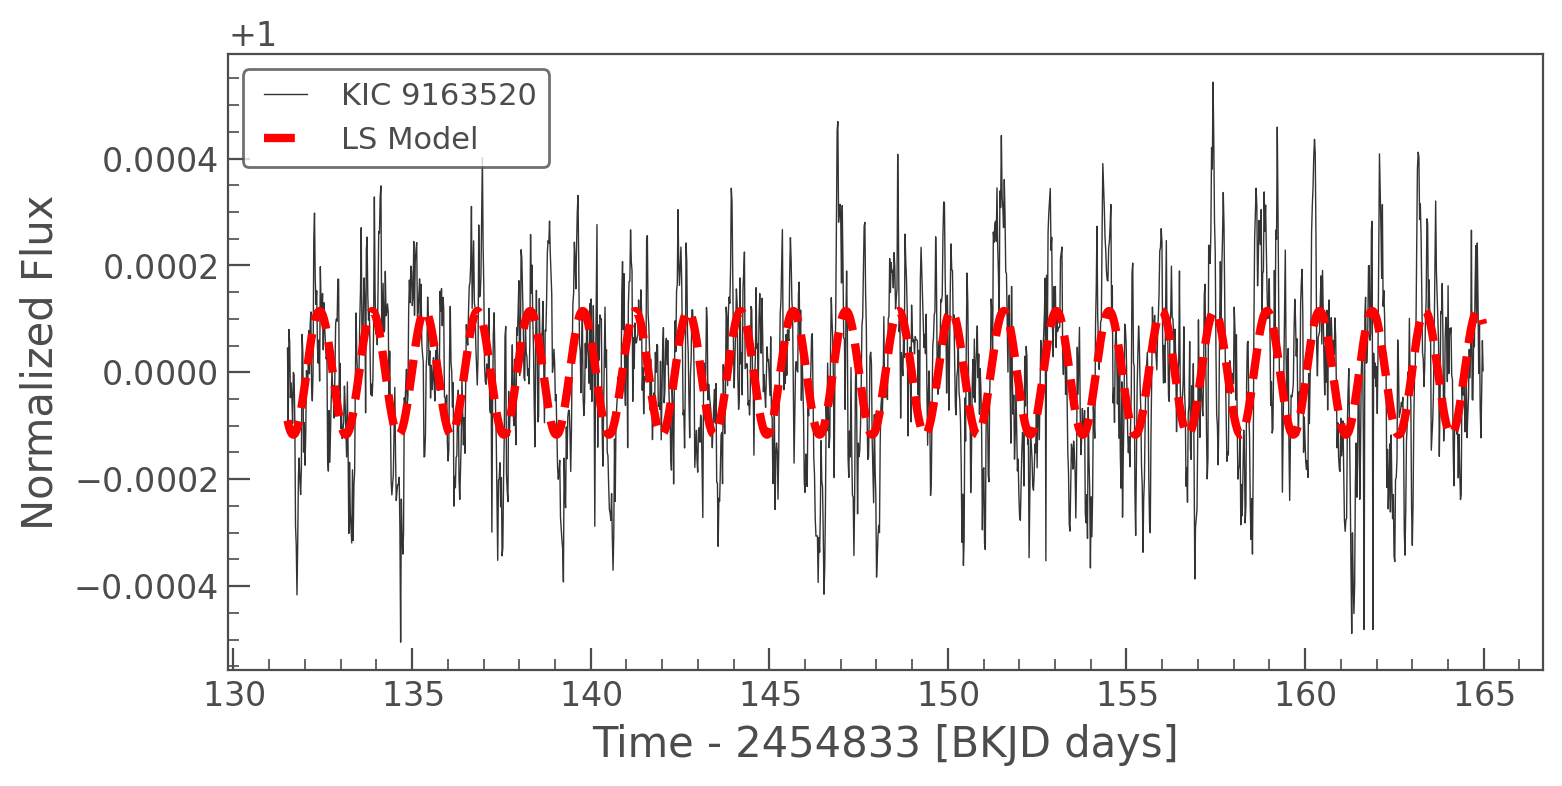

In [107]:
# Create a model light curve for the highest peak in the periodogram
clipped_lc = lc.remove_outliers(sigma=6)

lc_model = pg.model(time=clipped_lc.time, frequency=pg.frequency_at_max_power)

# Plot the light curve
ax = clipped_lc.plot()
# Plot the model light curve on top
lc_model.plot(ax=ax, lw=3, ls='--', c='red');

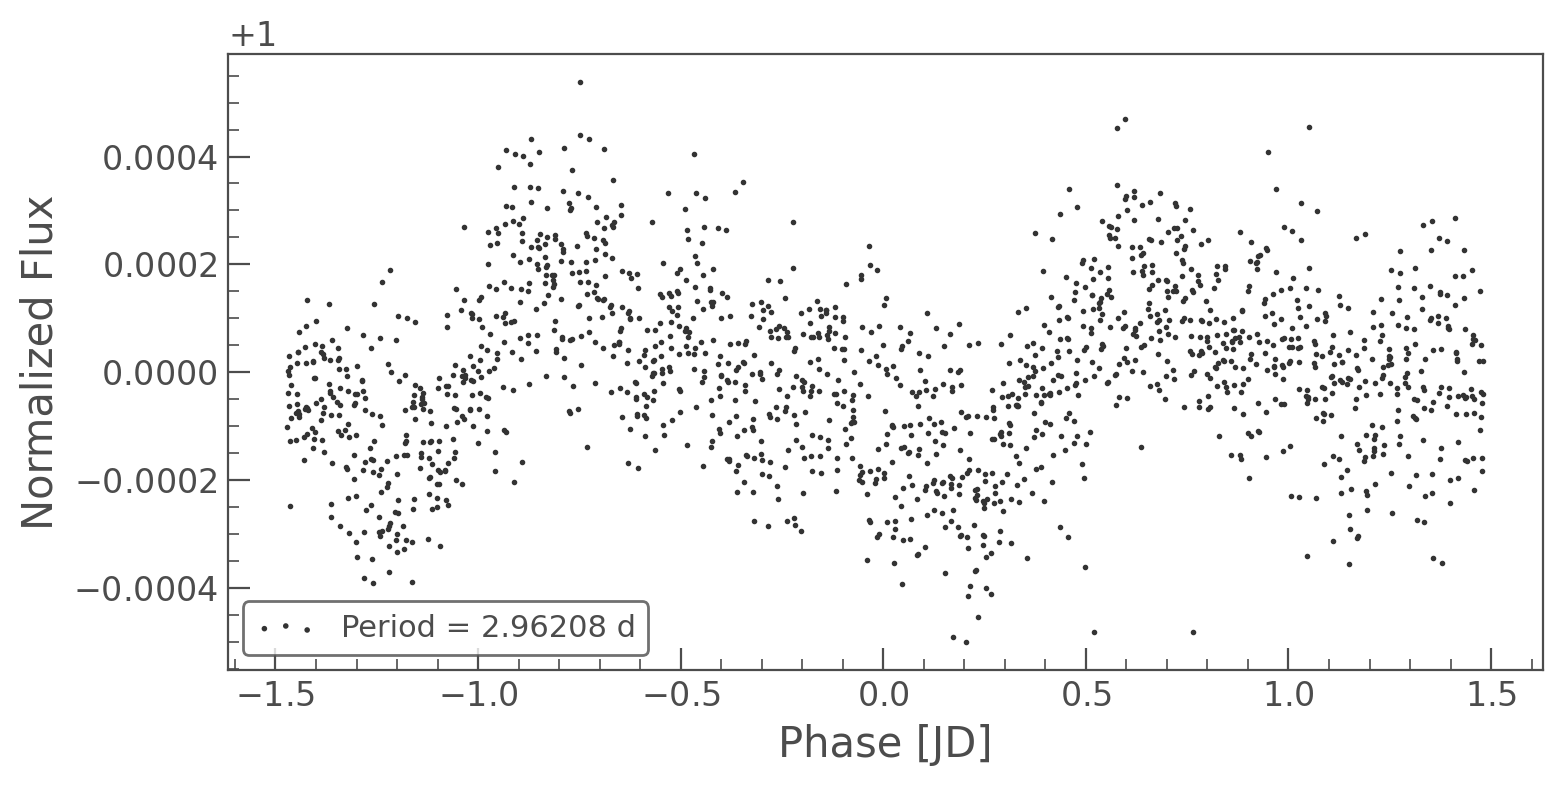

In [108]:
## Kepler DATA Analysis 
import lightkurve as lk
lc = lk.search_lightcurve('KIC 9163520', author="Kepler",quarter=1).download()
#pg = lc.normalize(unit='ppm').to_periodogram()
pg = lc.normalize(unit='ppm').to_periodogram()
period = pg.period_at_max_power

flat_lc = lc.flatten(window_length=1001)
clipped_lc = flat_lc.remove_outliers(sigma=6)
clipped_lc.fold(2*period).scatter(label=fr'Period = {2*period.value:.5f} d');

A = clipped_lc.remove_nans().fold(period=2*period).bin(time_bin_size=0.001)
t = A.phase.to_value('jd')+1.5
flux = A.flux

Note above we used P = 2p in the paper (p ~ 1.47 d)

## SPOT Modeling
We're going to use an estimate of $\delta L/L \sim 0.0006$, which comes from Eq. (3) with f=1 and the limits for the observed surface magnetic field (<10 G). Then the filling factor is accounted for by adjusting the value of the spot radius in the model

In [109]:
## Spot Properties (first Guess)
## We're using an estimate of DL/L ~ 0.0006, which comes from Eq. (3) with f=1 (filling factor is accounted for by radius below)
truth = dict(contrast=-0.0006, radius=45, lat=60, lon=30) # Note Negative Contrast = Bright Spot, Positive Contrast = Dark Spot

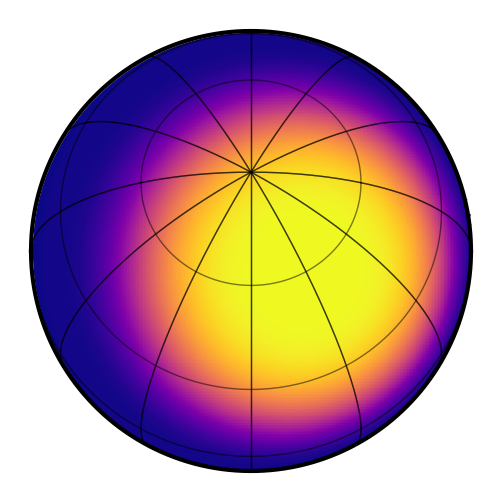

In [110]:
map = starry.Map(ydeg=10, udeg=2, rv=False)
map.inc = inc # Inclination angle  (21 Deg)
map.spot(
    contrast=truth["contrast"],
    radius=truth["radius"],
    lat=truth["lat"],
    lon=truth["lon"],
)
map.show()

In [10]:
map = starry.Map(ydeg=10, udeg=2, rv=True)
map.inc = inc
map.spot(
    contrast=truth["contrast"],
    radius=truth["radius"],
    lat=truth["lat"],
    lon=truth["lon"],
)

map.obl = 60 # Obliquity angle. Only matters for showing purposes 
map.veq = -vrot*1000 # in m/s (Positive or negative to determine direction of rotation)
#map.alpha = 0.3 # Surface shear. Not using it for now

map.show(rv=False, theta=np.linspace(0, 360, 50)) # Shows brightness map
map.show(rv=True, theta=np.linspace(0, 360, 50))  # Shows radial velocity map (note it's hard to see, but the spot change it from pure dipole)

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

### Generate Synthetic Light Curve with SPOT Model

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


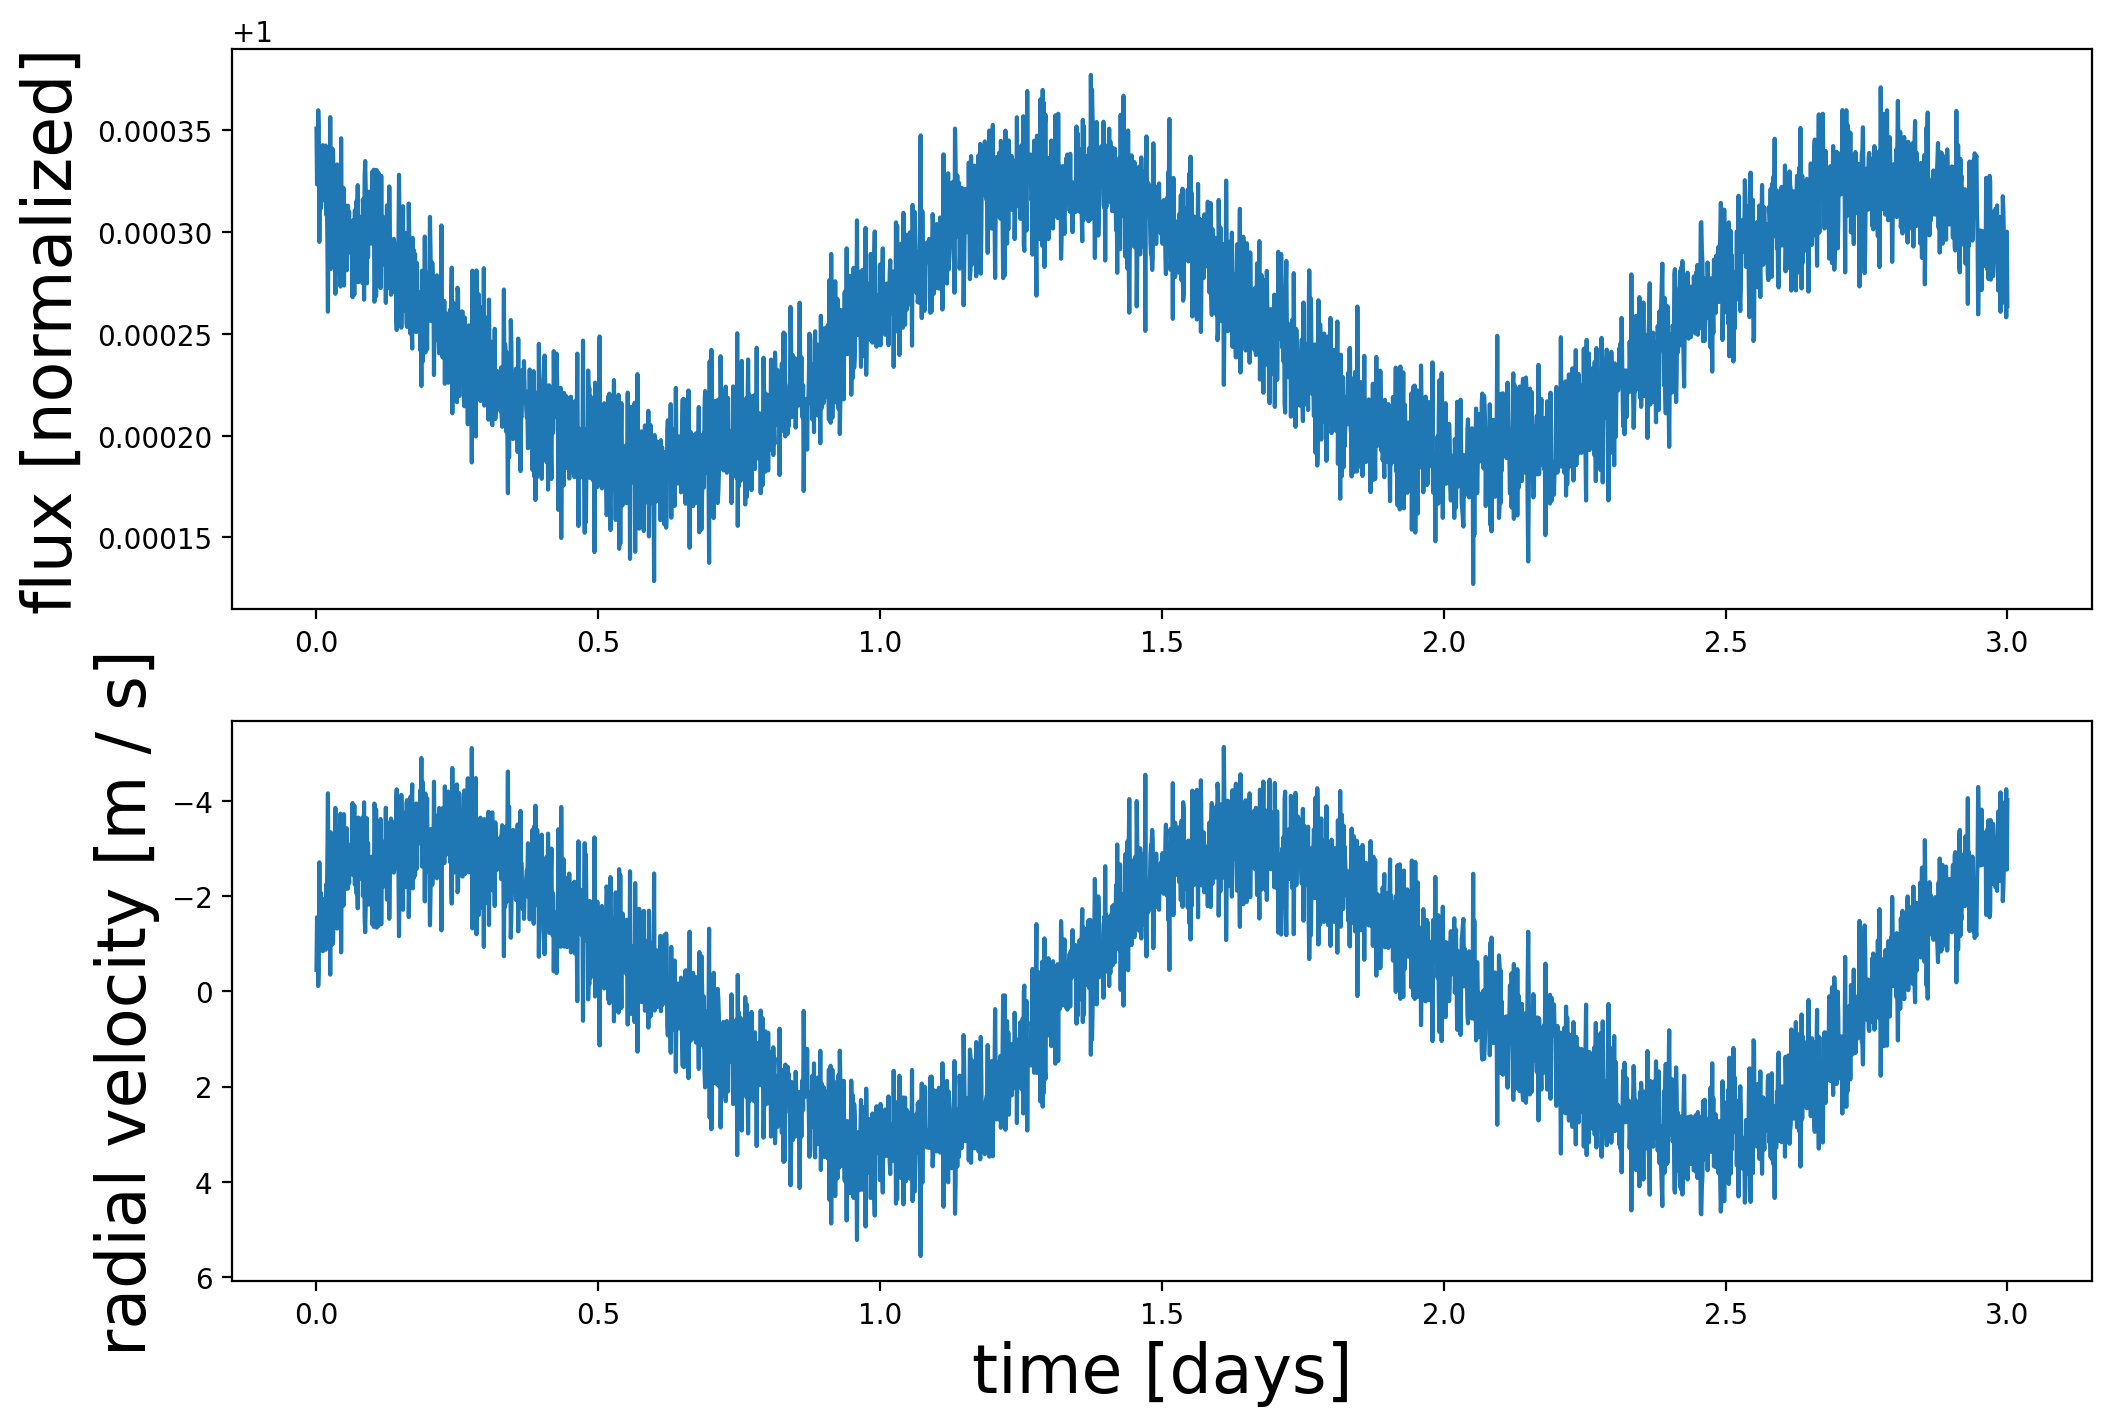

In [11]:
t = np.linspace(0, 3.0, 2951)

flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 2e-5
flux = flux0 + flux_err * np.random.randn(len(t))

# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 8e-1
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, flux_numpy)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])

ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [normalized]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

### Some Analytical Expectations for Luminosity and RV fluctuations
If a bright spot is changing the bolometric luminosity by a factor $\Delta L/L \approx2\times10^{-4}$ and the star is rotating with vsini$\approx$ 41 km/s, then one should expect a maximum doppler shift of something of the order $\delta v \sim f\,\Delta L/L\,$vsini, where $f$ is the filling factor. Plugging in numbers and remembering that the above 50\% filling factor this scaling breaks down (a spot can only blueshift or redshift half of the star at the time), one gets the max RV change to be $ 2\times10^{-4}*0.5*41\approx 4\times10^{-3}$ km/s or 4 m/s.
One can maybe get around this assuming many dark and bright spots distributed strategically, but it might be hard to do it.

### Let’s define a pymc3 model and within it, our priors and flux model

In [73]:
with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=-0.01, upper=0.0, testval=-0.0001)
    radius = pm.Uniform("radius", lower=30.0, upper=70.0, testval=40)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)

    # Instantiate the map and add the spot
    #map = starry.Map(ydeg=15)
    map = starry.Map(ydeg=15, udeg=2)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)
    # To Add Limb Darkening
    #map = starry.Map(ydeg=15, udeg=2)
    map[1] = 0.5
    map[2] = 0.25

    # Compute the flux model
    flux_model = map.flux(theta=360.0 / P * t)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=A.flux)

/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [74]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [obs_missing, lon, lat, radius, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -19802.15751114011 -> -10736.193031397823


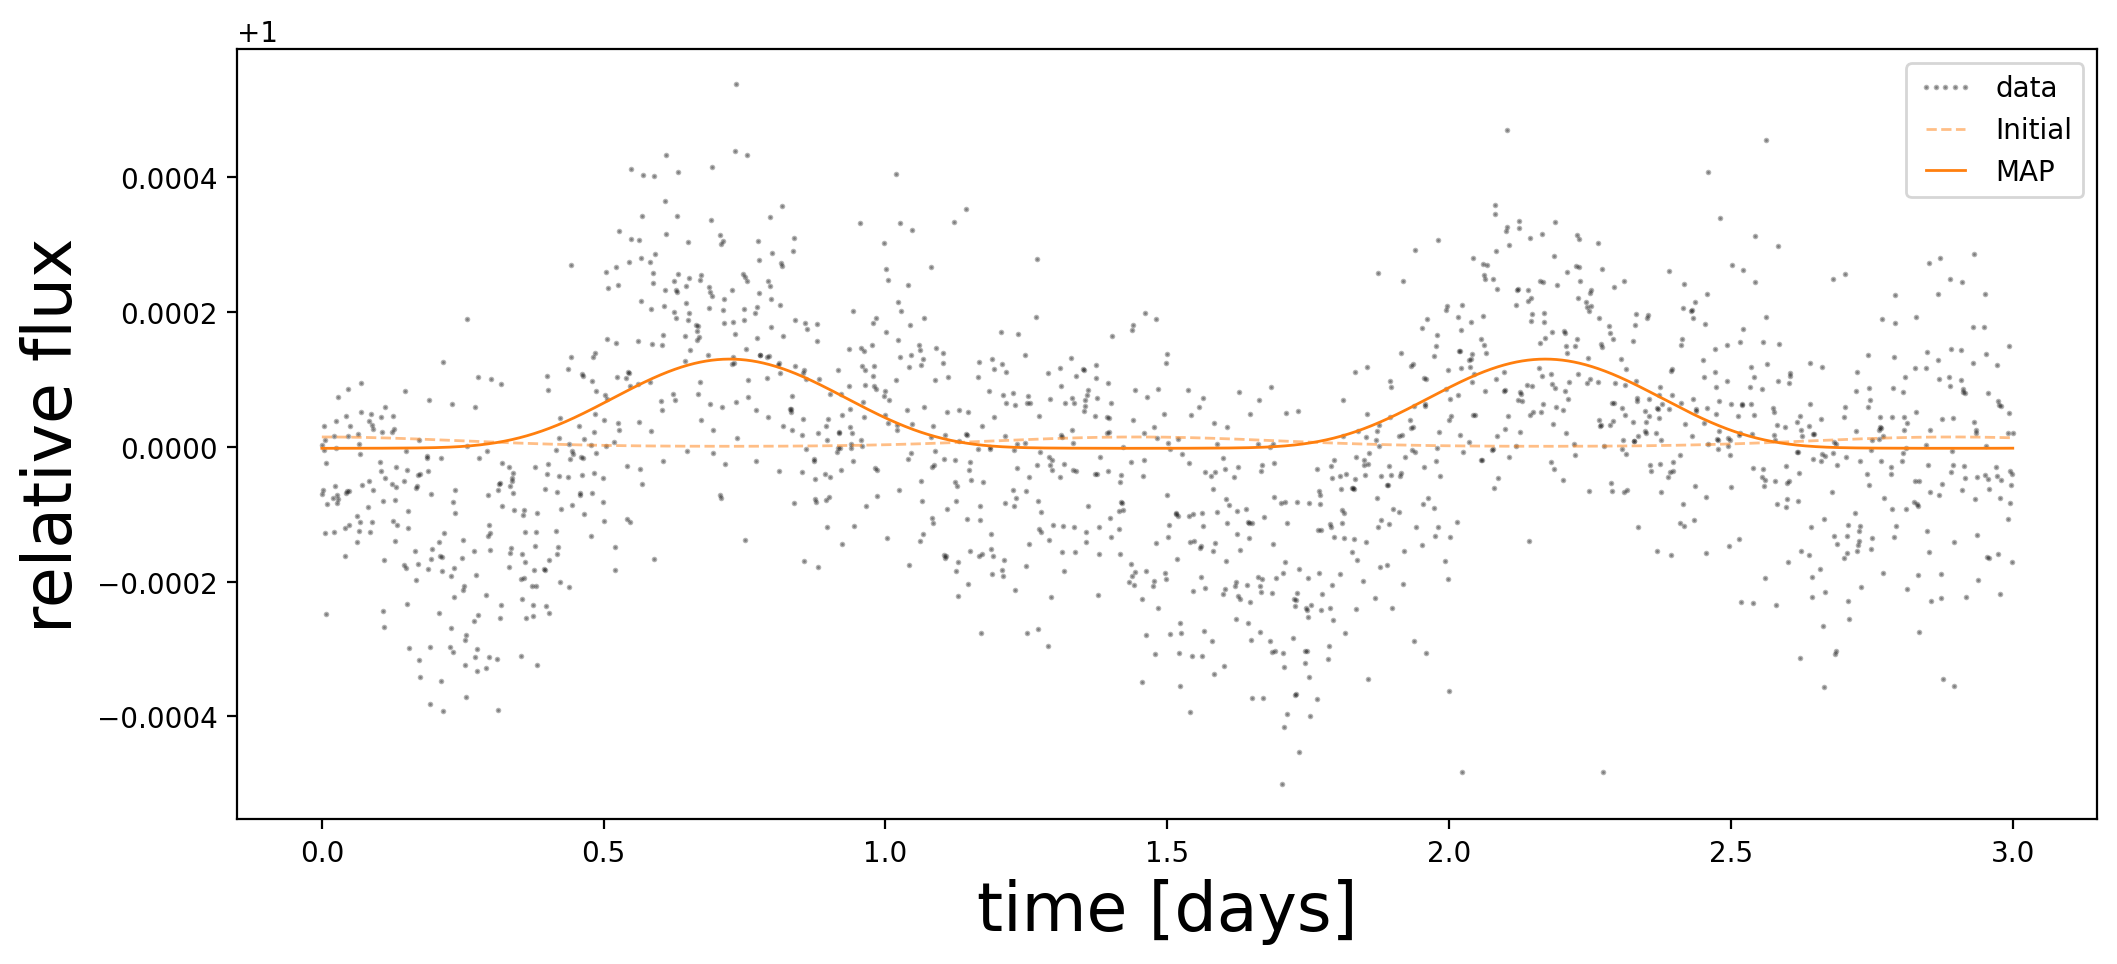

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(t, A.flux, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [76]:
print("{0:12s} {1:10s} {2:10s}".format("", "truth", "map_soln"))
for key in truth.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth[key], map_soln[key]))

             truth      map_soln  
contrast     -0.00060   -0.00995
radius       45.00000   61.45667
lat          60.00000  -62.90707
lon          30.00000  180.00000


In [77]:
with model:
    #trace = pmx.sample(tune=250, draws=500, start=map_soln, chains=4, target_accept=0.9)
    trace = pm.sample(tune=1000, draws=500, start=map_soln, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [obs_missing, lon, lat, radius, contrast]


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/

In [79]:
var_names = ["contrast", "radius", "lat", "lon"]
display(pm.summary(trace, var_names=var_names))

Got error No model on context stack. trying to find log_likelihood in translation.


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
contrast   -0.010  0.000   -0.010   -0.010      0.000    0.000    2590.0   
radius     62.144  0.200   61.780   62.518      0.003    0.002    3892.0   
lat       -63.507  0.240  -63.944  -63.070      0.004    0.003    3603.0   
lon       170.511  0.415  169.656  171.238      0.007    0.005    3728.0   

          ess_tail  r_hat  
contrast    1257.0    1.0  
radius      1738.0    1.0  
lat         1408.0    1.0  
lon         1541.0    1.0

Pandas support in corner is deprecated; use ArviZ directly


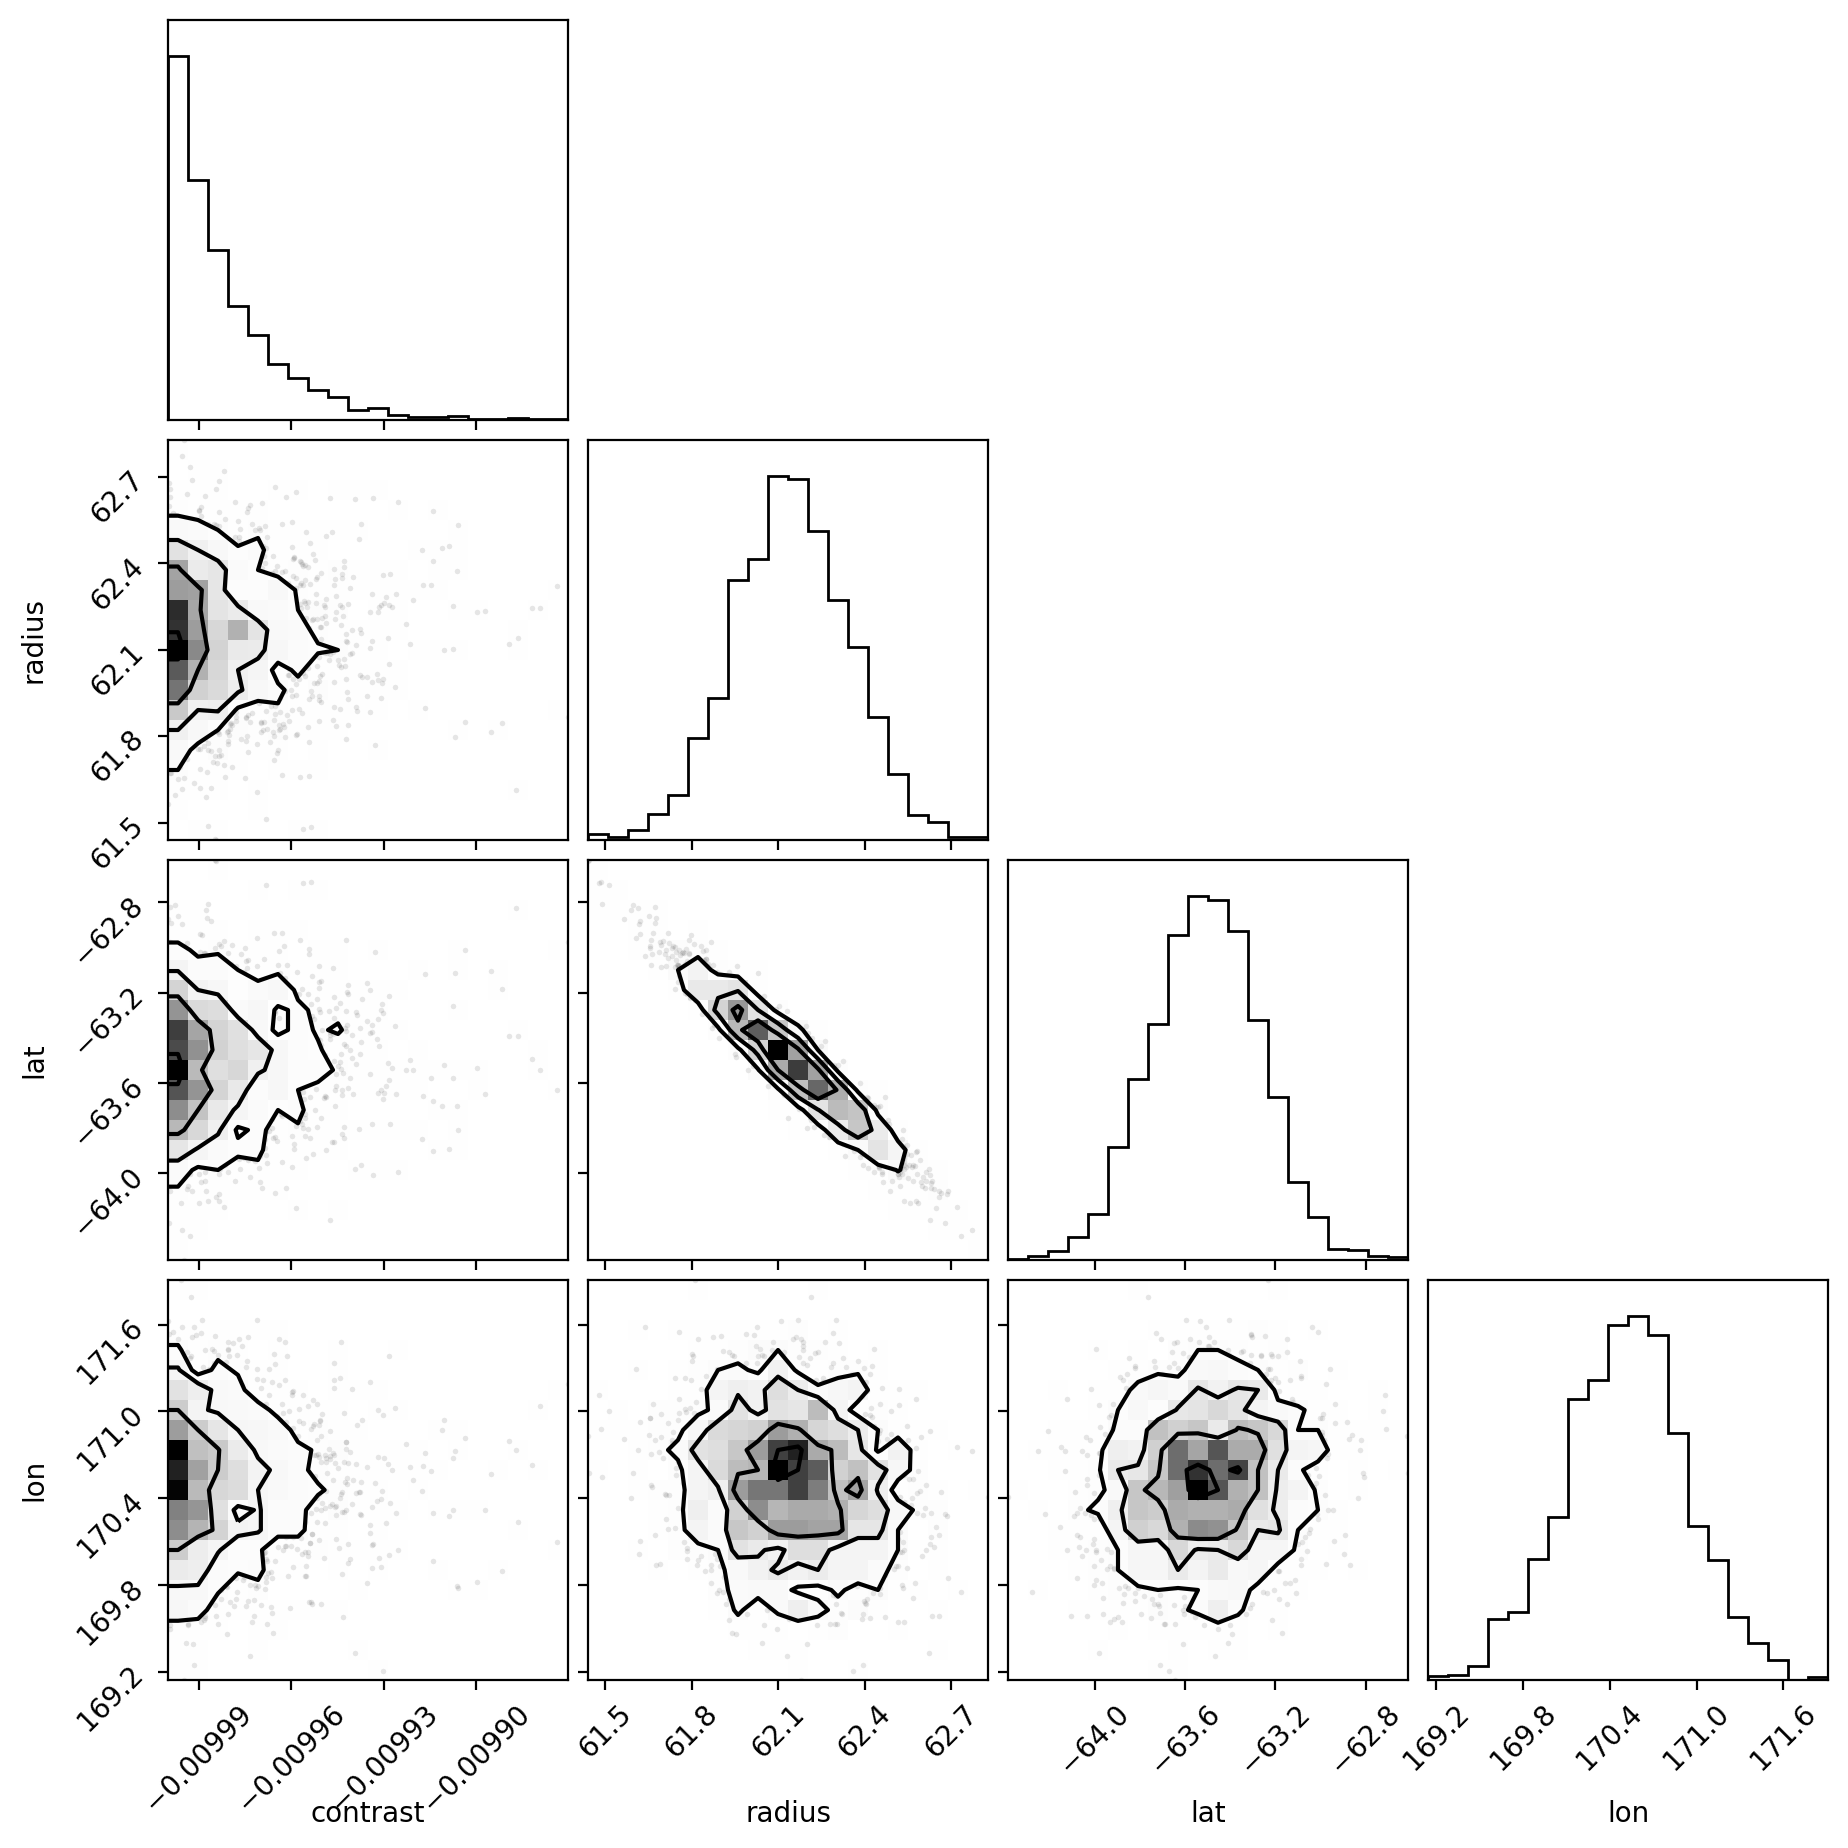

In [80]:
samples = pm.trace_to_dataframe(trace, varnames=var_names)
corner(samples, truths=[truth[name] for name in var_names]);

To extend this to multiple spots, call map.spot once for each spot in the model, making sure to define new pymc3 variables for the spot properties of each spot.

## Multiple SPOTS Model

We're going to start with a two spots model that tries to account for a bright spot surrounded by a dark ring. This configuration is inspired by flux conservation arguments, although it's unclear what these out-of-thermal equilibrium spots could look like. In the Sun 
it is known that extra flux emerges from the regions surrounding dark spots. So it's possible a similar phenomena occurs for bright spots.

In [191]:
# True values
truth1 = dict(contrast1=-0.0020, radius1=50, lat1=25, lon1=30)  # Remember the brightness of the bright spot is contrast1 + Contrast 2 !!
truth2 = dict(contrast2=+0.0008, radius2=85, lat2=25, lon2=30)

truth1 = dict(contrast1=-0.0019, radius1=50, lat1=25, lon1=30)  # Remember the brightness of the bright spot is contrast1 + Contrast 2 !!
truth2 = dict(contrast2=+0.0008, radius2=85, lat2=25, lon2=30)

truth3 = dict(contrast3=-0.004, radius3=20, lat3=25, lon3=280)
truth4 = dict(contrast4=+0.002, radius4=25, lat4=25, lon4=280)

In [192]:
map = starry.Map(ydeg=10,udeg=2,rv=True)
map.inc = inc
map.spot(
    contrast=truth1["contrast1"],
    radius=truth1["radius1"],
    lat=truth1["lat1"],
    lon=truth1["lon1"],
)
map.spot(
    contrast=truth2["contrast2"],
    radius=truth2["radius2"],
    lat=truth2["lat2"],
    lon=truth2["lon2"],
)

# map.spot(
#     contrast=truth3["contrast3"],
#     radius=truth3["radius3"],
#     lat=truth3["lat3"],
#     lon=truth3["lon3"],
# )
# map.spot(
#     contrast=truth4["contrast4"],
#     radius=truth4["radius4"],
#     lat=truth4["lat4"],
#     lon=truth4["lon4"],
# )

vrot = 113 # km/s
map.obl = 60
map.veq = -vrot*1000 # in m/s

map.show(rv=False, theta=np.linspace(0, 360, 50))
map.show(rv=True, theta=np.linspace(0, 360, 50))

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

### Synthetic Lightcurve

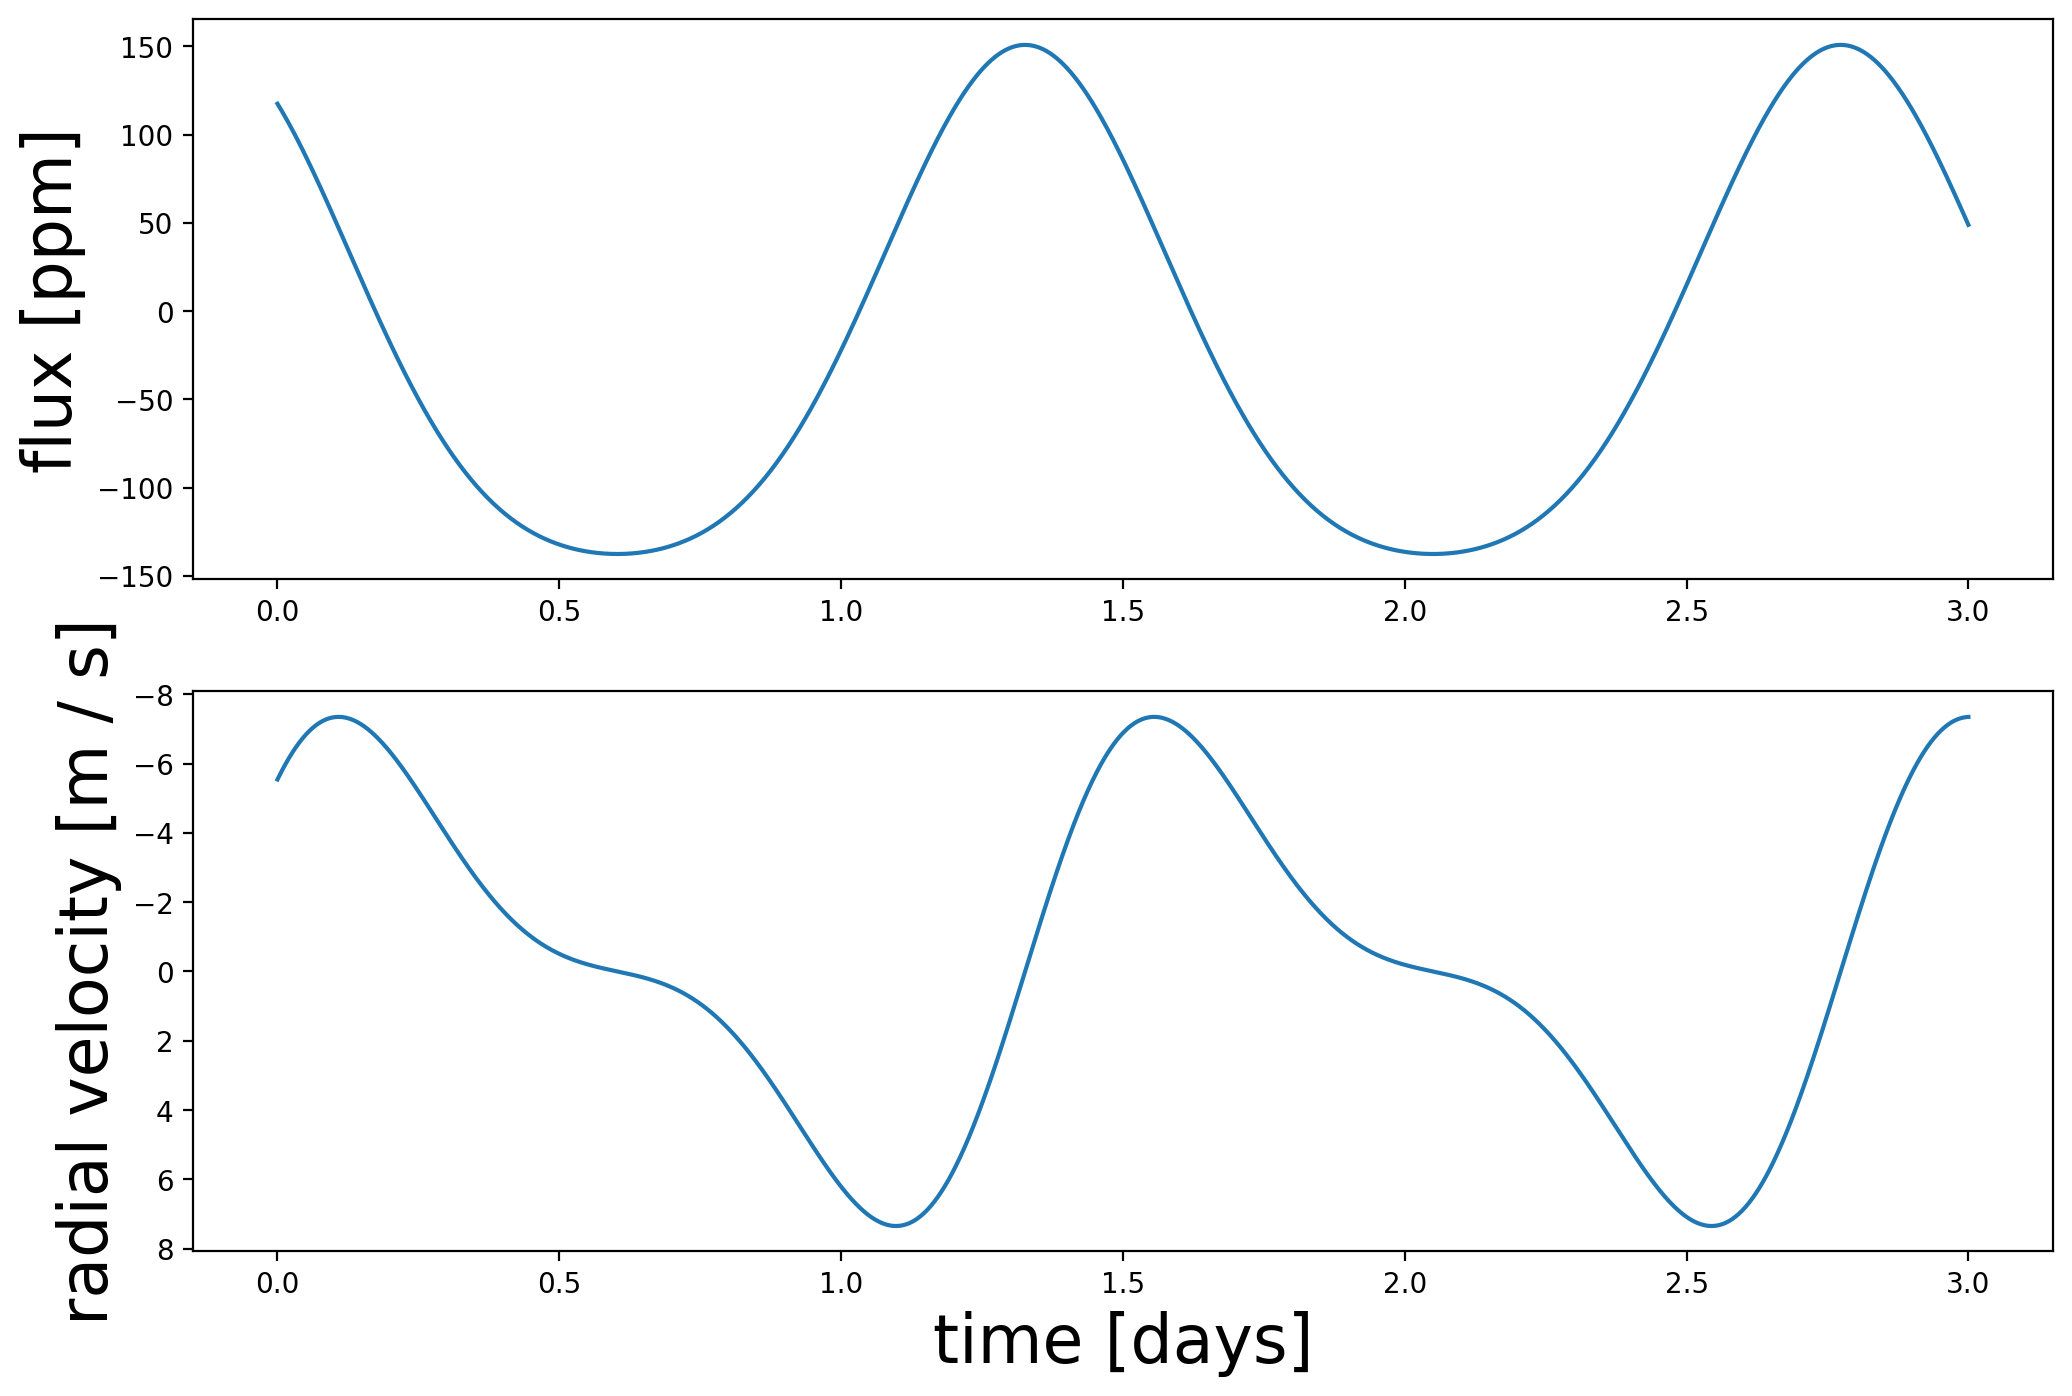

In [193]:
t = np.linspace(0, 3, 1481) # This should be (0,3,2951) to make it work with the observed dataset

flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 0# 1e-5
flux = flux0 + flux_err * np.random.randn(len(t))

# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 0 # 8e-1
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

ppm = 1e-6
# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, (flux_numpy-1)/ppm)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [ppm]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

### Some Important Considerations
This 2 Spots model can reproduce a number of features in the Kepler observations. The lightcurve is reproduced both qualitatively  and quantitatively (approximately). The RV series is reproduced qualitatively, showing the most important expected features (0 km/s at the brightness peak, and the right red/blue-shift pattern). Note that we had to choose a specific direction of rotation to make this look like the observation. The biggest challenge remains the amplitude of the RV fluctuations, which is off by a factor of about 20. It seems hard to explain RV and photometry purely with spots. Pulsations are likely to be occurring. 

### Overplot Data

In [136]:
search_result_2022 = lk.search_lightcurve('KIC 9163520', mission='TESS', sector = 55)
lc_2022 = search_result_2022.download_all()
lc_2022

LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

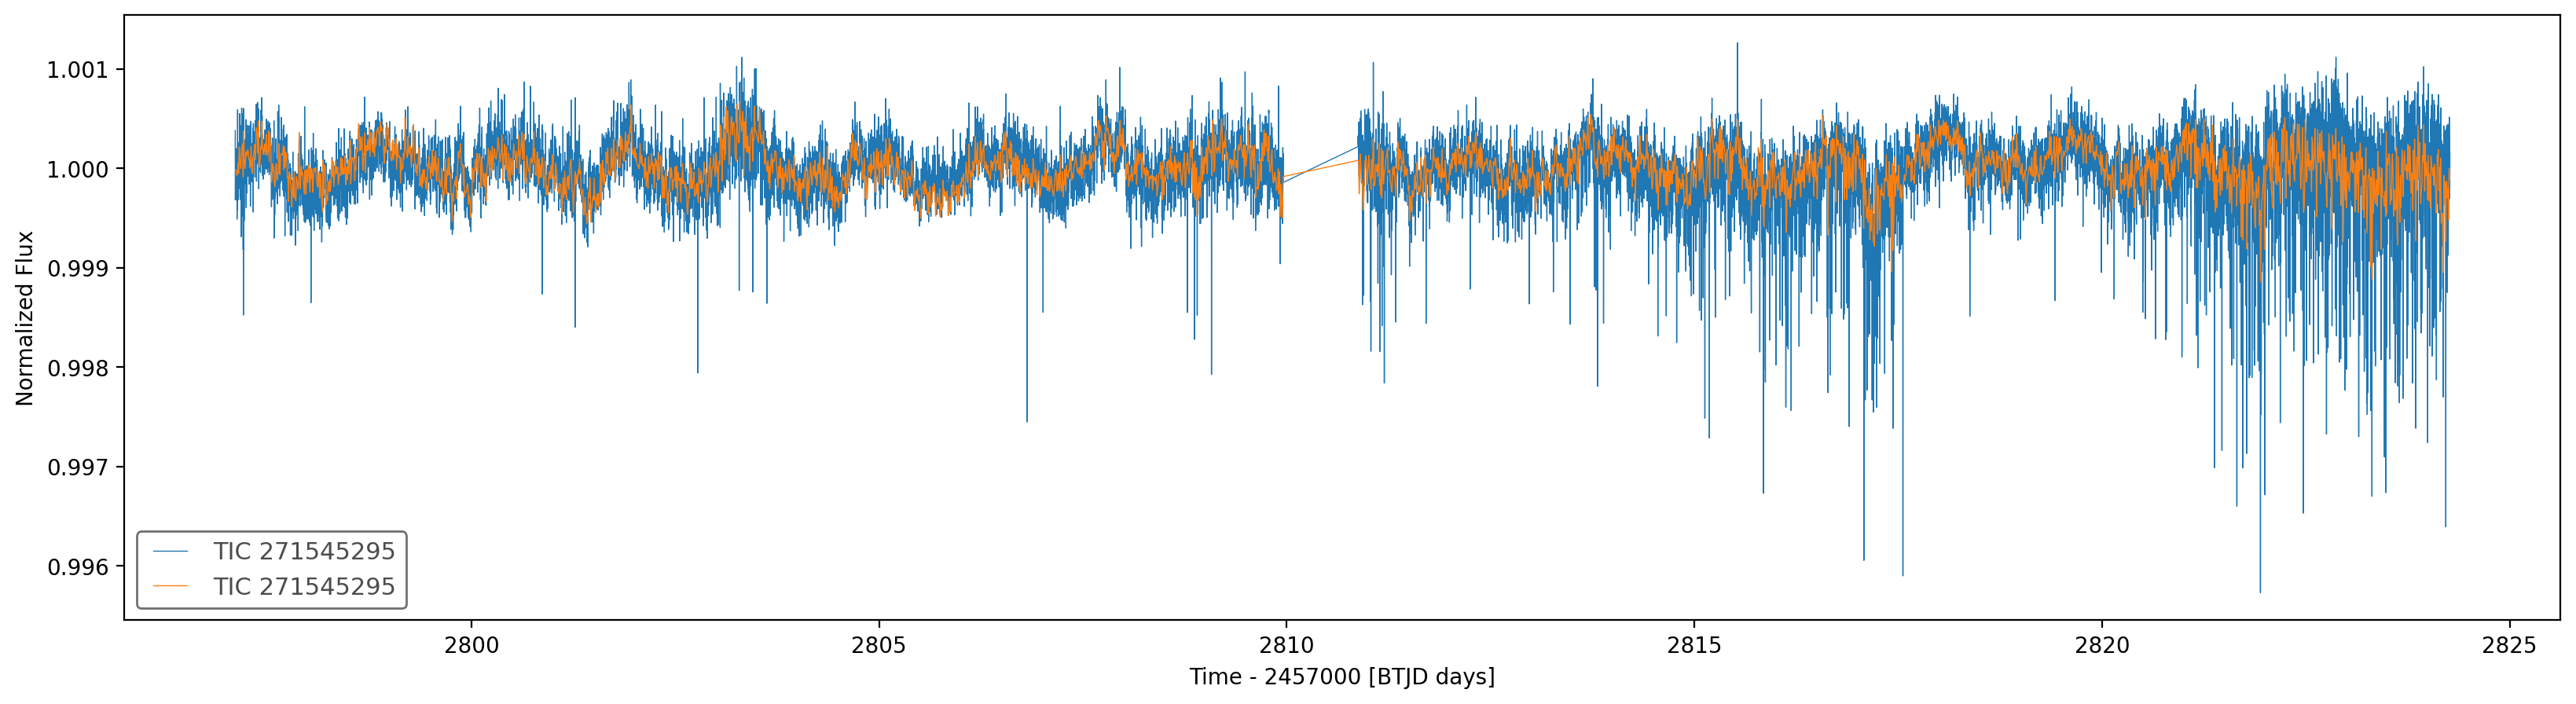

In [137]:
fig, ax = plt.subplots(figsize=(20,5))
lc_2022[0].plot(ax=ax,normalize=True);
lc_2022[1].plot(ax=ax,normalize=True);

In [138]:
pg = lc_2022[1].normalize(unit='ppm').to_periodogram()
period = pg.period_at_max_power
print(period)

1.4756817854920776 d


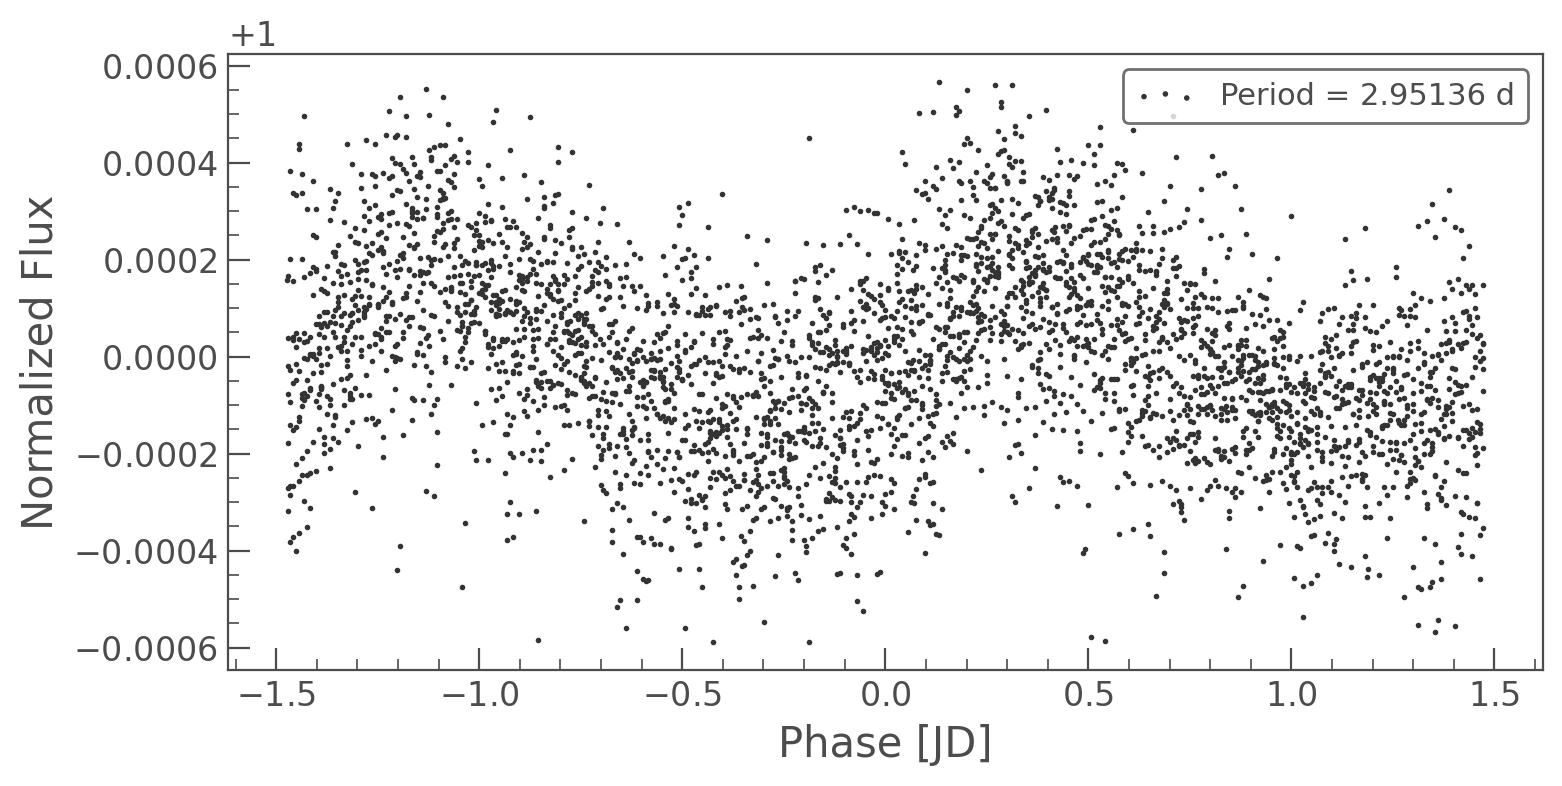

In [139]:
flat_lc = lc_2022[1].flatten(window_length=1001)
clipped_lc = flat_lc.remove_outliers(sigma=3)
folding=2.0*period
clipped_lc.fold(folding).scatter(label=fr'Period = {folding.value:.5f} d');

A = clipped_lc.fold(period=folding) 
t_data = A.phase.to_value('jd')#+1.5
flux_data = A.flux

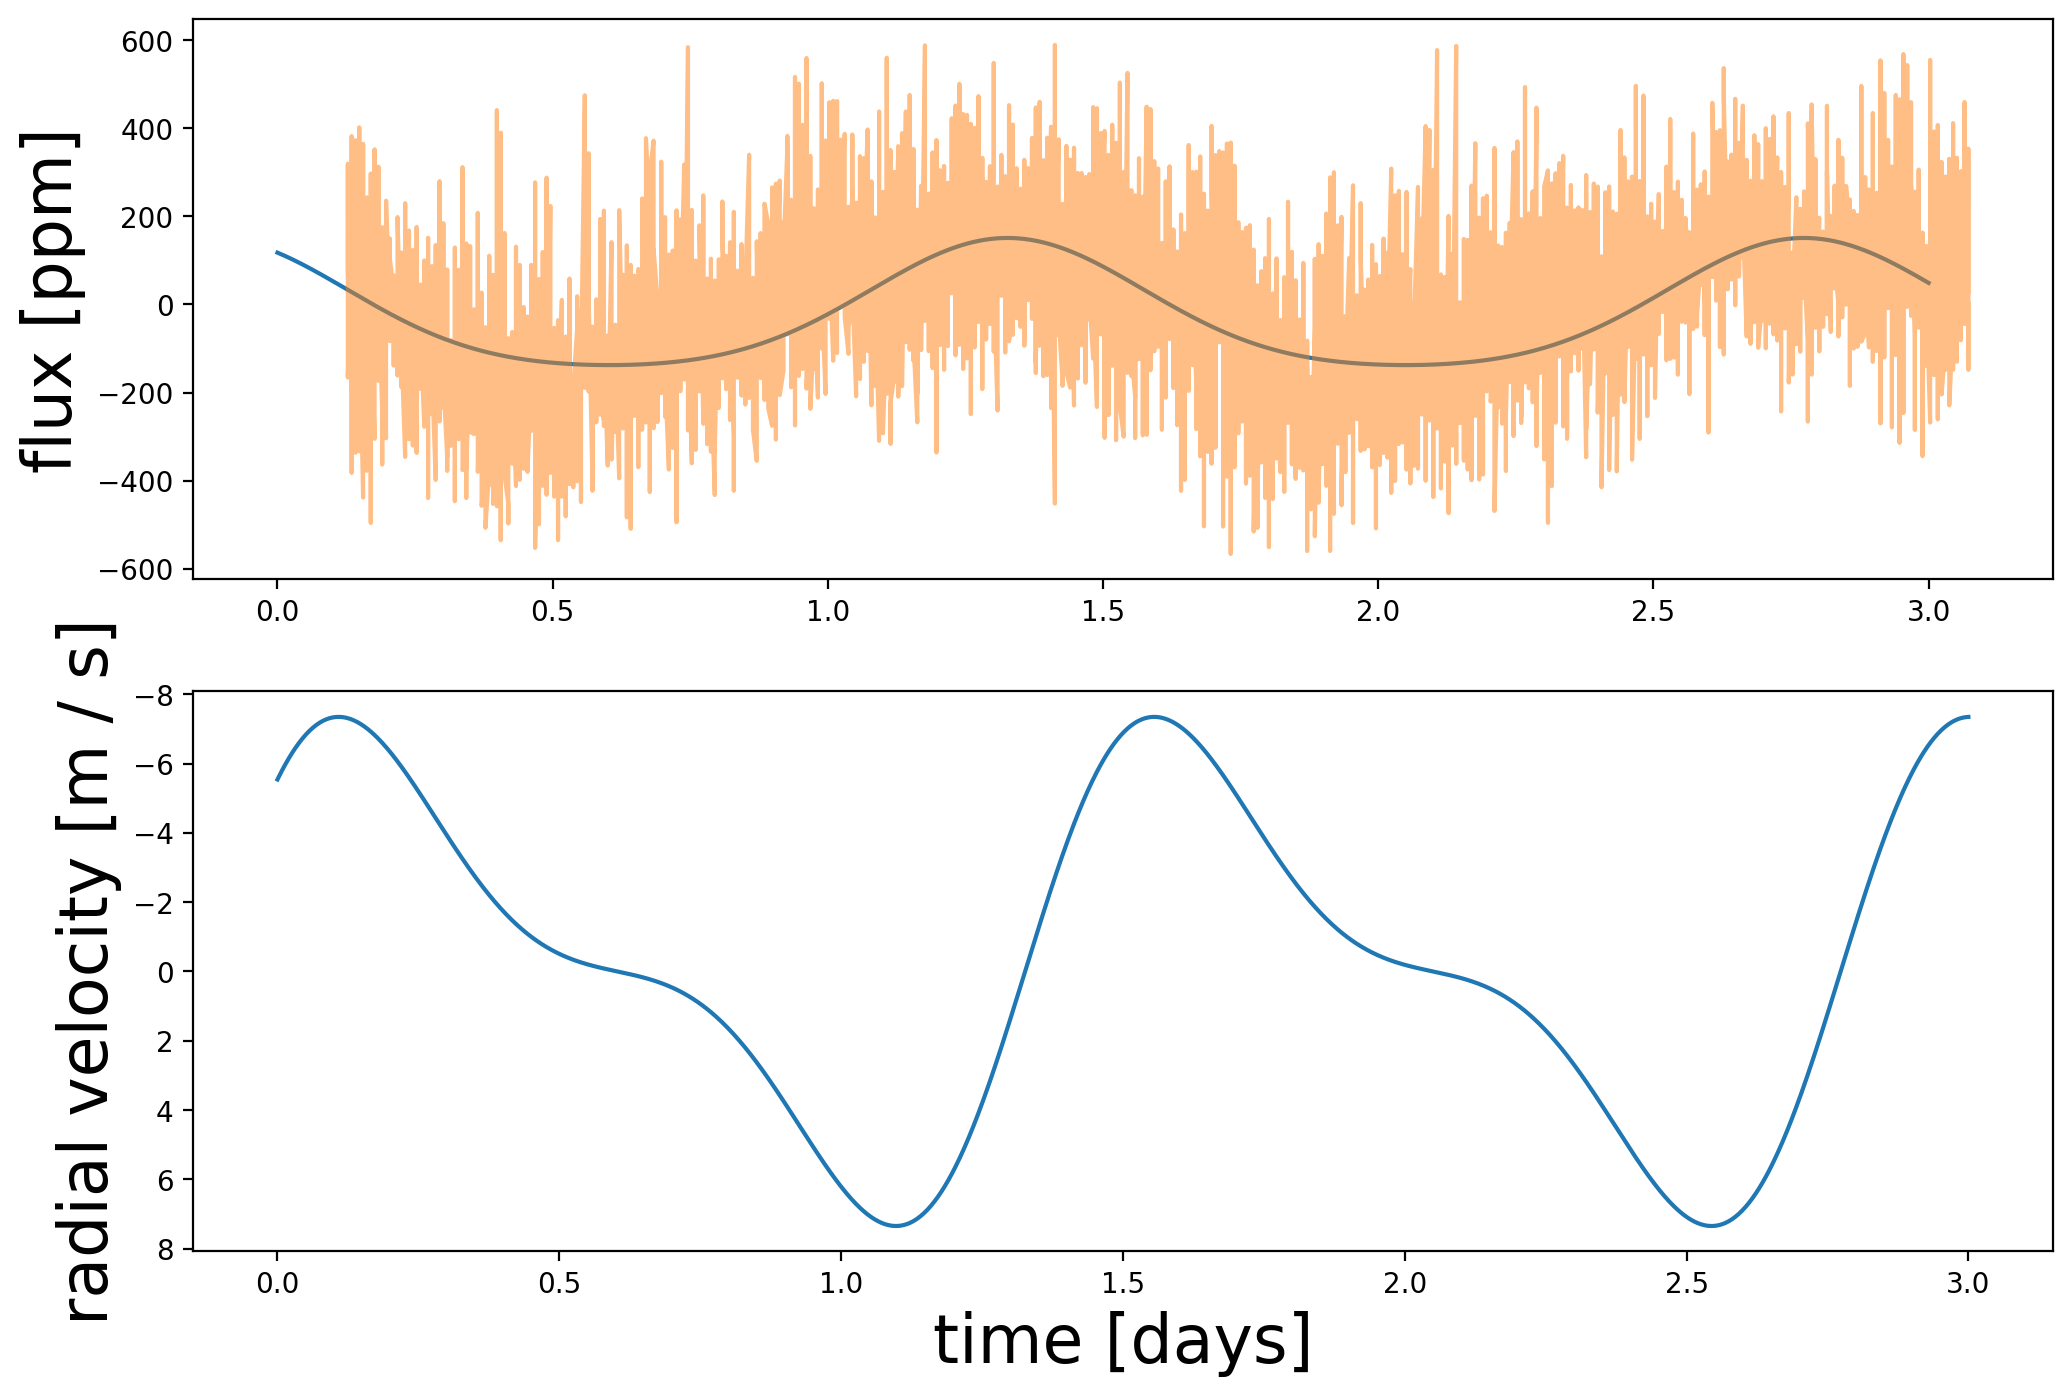

In [194]:
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, (flux_numpy-1)/ppm)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [ppm]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

ax[0].plot(t_data+1.6, -(flux_data-1)/ppm,alpha=0.5)


In [120]:
# True values
truth1 = dict(contrast1=-0.013, radius1=50, lat1=25, lon1=30)  # Remember the brightness of the bright spot is contrast1 + Contrast 2 !!
truth2 = dict(contrast2=+0.005, radius2=85, lat2=25, lon2=30)

truth3 = dict(contrast3=+0.04, radius3=20, lat3=25, lon3=60)
truth4 = dict(contrast4=+0.02, radius4=25, lat4=25, lon4=280)

truth5 = dict(contrast5=+0.04, radius5=20, lat5=25, lon5=180)
truth6 = dict(contrast6=+0.02, radius6=25, lat6=25, lon6=120)

In [121]:
map = starry.Map(ydeg=10,udeg=2,rv=True)
map.inc = inc
map.spot(
    contrast=truth1["contrast1"],
    radius=truth1["radius1"],
    lat=truth1["lat1"],
    lon=truth1["lon1"],
)
map.spot(
    contrast=truth2["contrast2"],
    radius=truth2["radius2"],
    lat=truth2["lat2"],
    lon=truth2["lon2"],
)

map.spot(
     contrast=truth3["contrast3"],
     radius=truth3["radius3"],
     lat=truth3["lat3"],
     lon=truth3["lon3"],
 )
map.spot(
     contrast=truth4["contrast4"],
     radius=truth4["radius4"],
     lat=truth4["lat4"],
     lon=truth4["lon4"],
 )

map.spot(
     contrast=truth5["contrast5"],
     radius=truth5["radius5"],
     lat=truth5["lat5"],
     lon=truth5["lon5"],
 )
map.spot(
     contrast=truth6["contrast6"],
     radius=truth6["radius6"],
     lat=truth6["lat6"],
     lon=truth6["lon6"],
 )

vrot = 113 # km/s
map.obl = 60
map.veq = -vrot*1000 # in m/s

map.show(rv=False, theta=np.linspace(0, 360, 50))
map.show(rv=True, theta=np.linspace(0, 360, 50))

# Limb Darkening
map[1] = 0.5
map[2] = 0.25

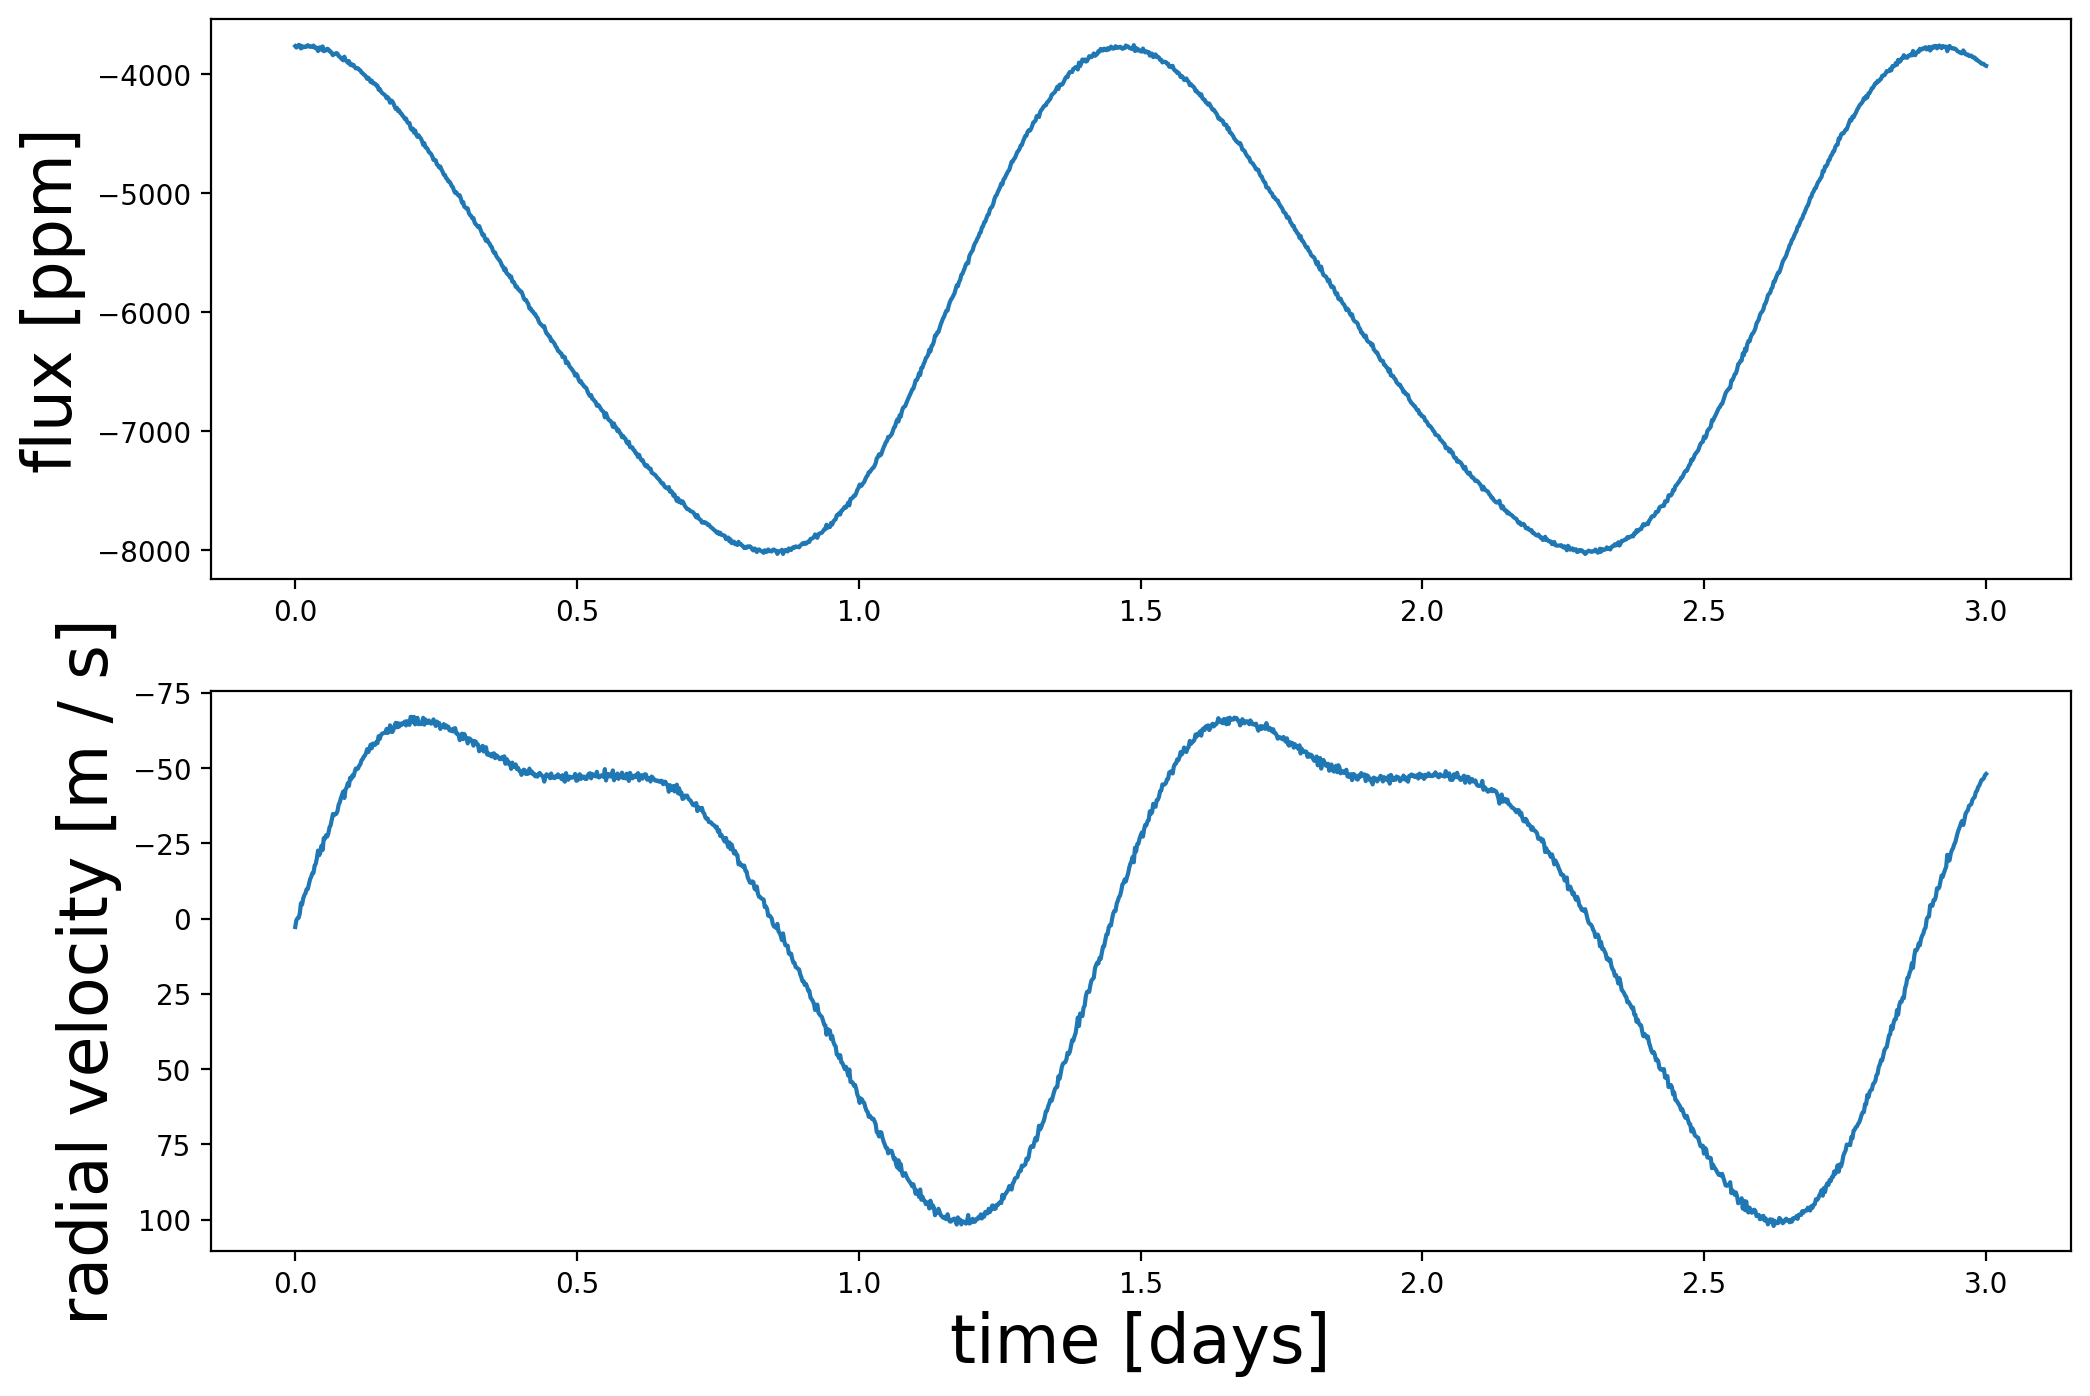

In [122]:
t = np.linspace(0, 3, 1481) # This should be (0,3,2951) to make it work with the observed dataset

flux0 = map.flux(theta=360.0 / P * t)
np.random.seed(0)
flux_err = 1e-5
flux = flux0 + flux_err * np.random.randn(len(t))

# Compute the  RV signal
rv0 = map.rv(theta=360.0 / P * t)
np.random.seed(0)
rv_err = 8e-1
rv = rv0 + rv_err * np.random.randn(len(t))

flux_numpy = flux.eval()
rv_numpy = rv.eval()

ppm = 1e-6
# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(t, (flux_numpy-1)/ppm)
ax[1].plot(t, rv_numpy)
ax[1].set_ylim(ax[1].get_ylim()[::-1])
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [ppm]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);

In [15]:
search_result = lk.search_targetpixelfile('KIC 9163520', mission='TESS')


In [16]:
search_result

SearchResult containing 12 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 14 2019      SPOC     120   271545295      0.0
  1 TESS Sector 15 2019      SPOC     120   271545295      0.0
  2 TESS Sector 40 2021      SPOC     120   271545295      0.0
  3 TESS Sector 41 2021      SPOC     120   271545295      0.0
  4 TESS Sector 55 2022      SPOC     120   271545295      0.0
  5 TESS Sector 74 2024      SPOC     120   271545295      0.0
  6 TESS Sector 75 2024      SPOC     120   271545295      0.0
  7 TESS Sector 14 2019 TESS-SPOC    1800   271545295      0.0
  8 TESS Sector 15 2019 TESS-SPOC    1800   271545295      0.0
  9 TESS Sector 40 2021 TESS-SPOC     600   271545295      0.0
 10 TESS Sector 41 2021 TESS-SPOC     600   271545295      0.0
 11 TESS Sector 55 2022 TESS-SPOC     600   271545295      0.0

In [17]:
search_result_2022 = lk.search_targetpixelfile('KIC 9163520', mission='TESS', sector = 55)
tpf_2022 = search_result_2022.download_all()

In [18]:
tpf_2022

TargetPixelFileCollection of 2 objects:
    0: TessTargetPixelFile(TICID: 271545295)
    1: TessTargetPixelFile(TICID: 271545295)

In [19]:
search_result_2022 = lk.search_lightcurve('KIC 9163520', mission='TESS', sector = 55)
lc_2022 = search_result_2022.download_all()
lc_2022

LightCurveCollection of 3 objects:
    0: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 271545295" SECTOR=55 AUTHOR=QLP FLUX_ORIGIN=sap_flux>

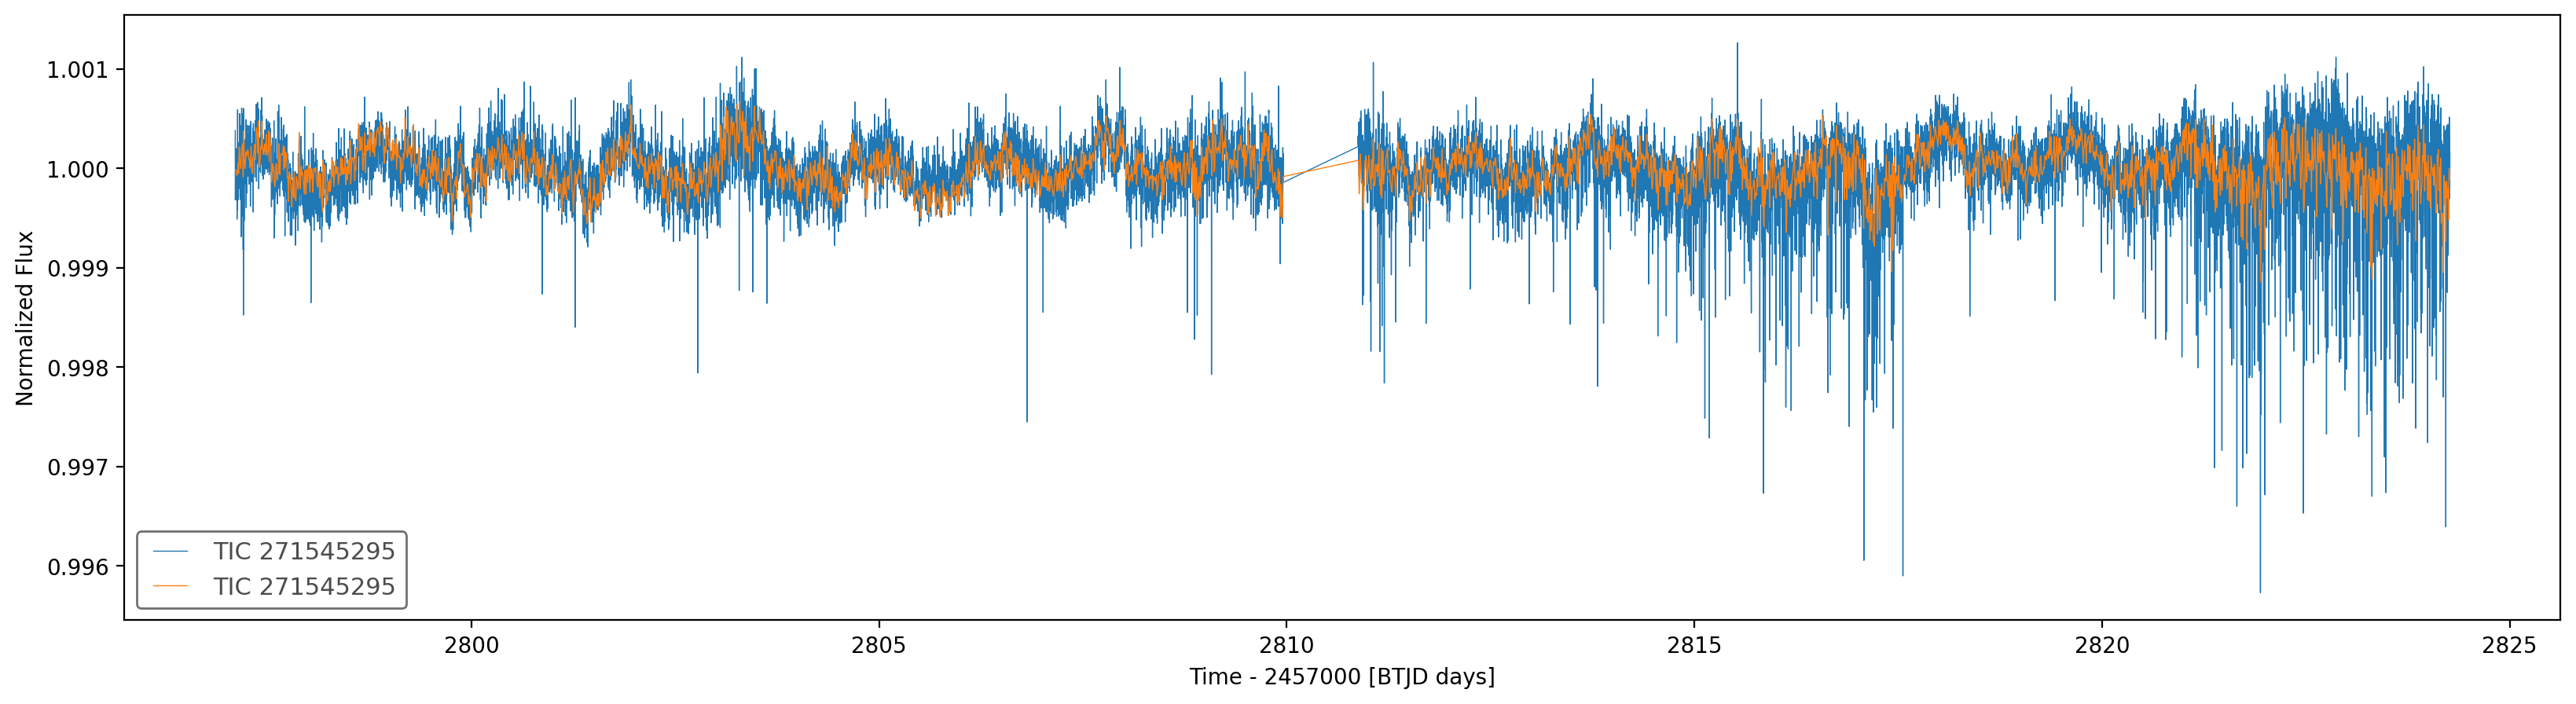

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
lc_2022[0].plot(ax=ax,normalize=True);
lc_2022[1].plot(ax=ax,normalize=True);

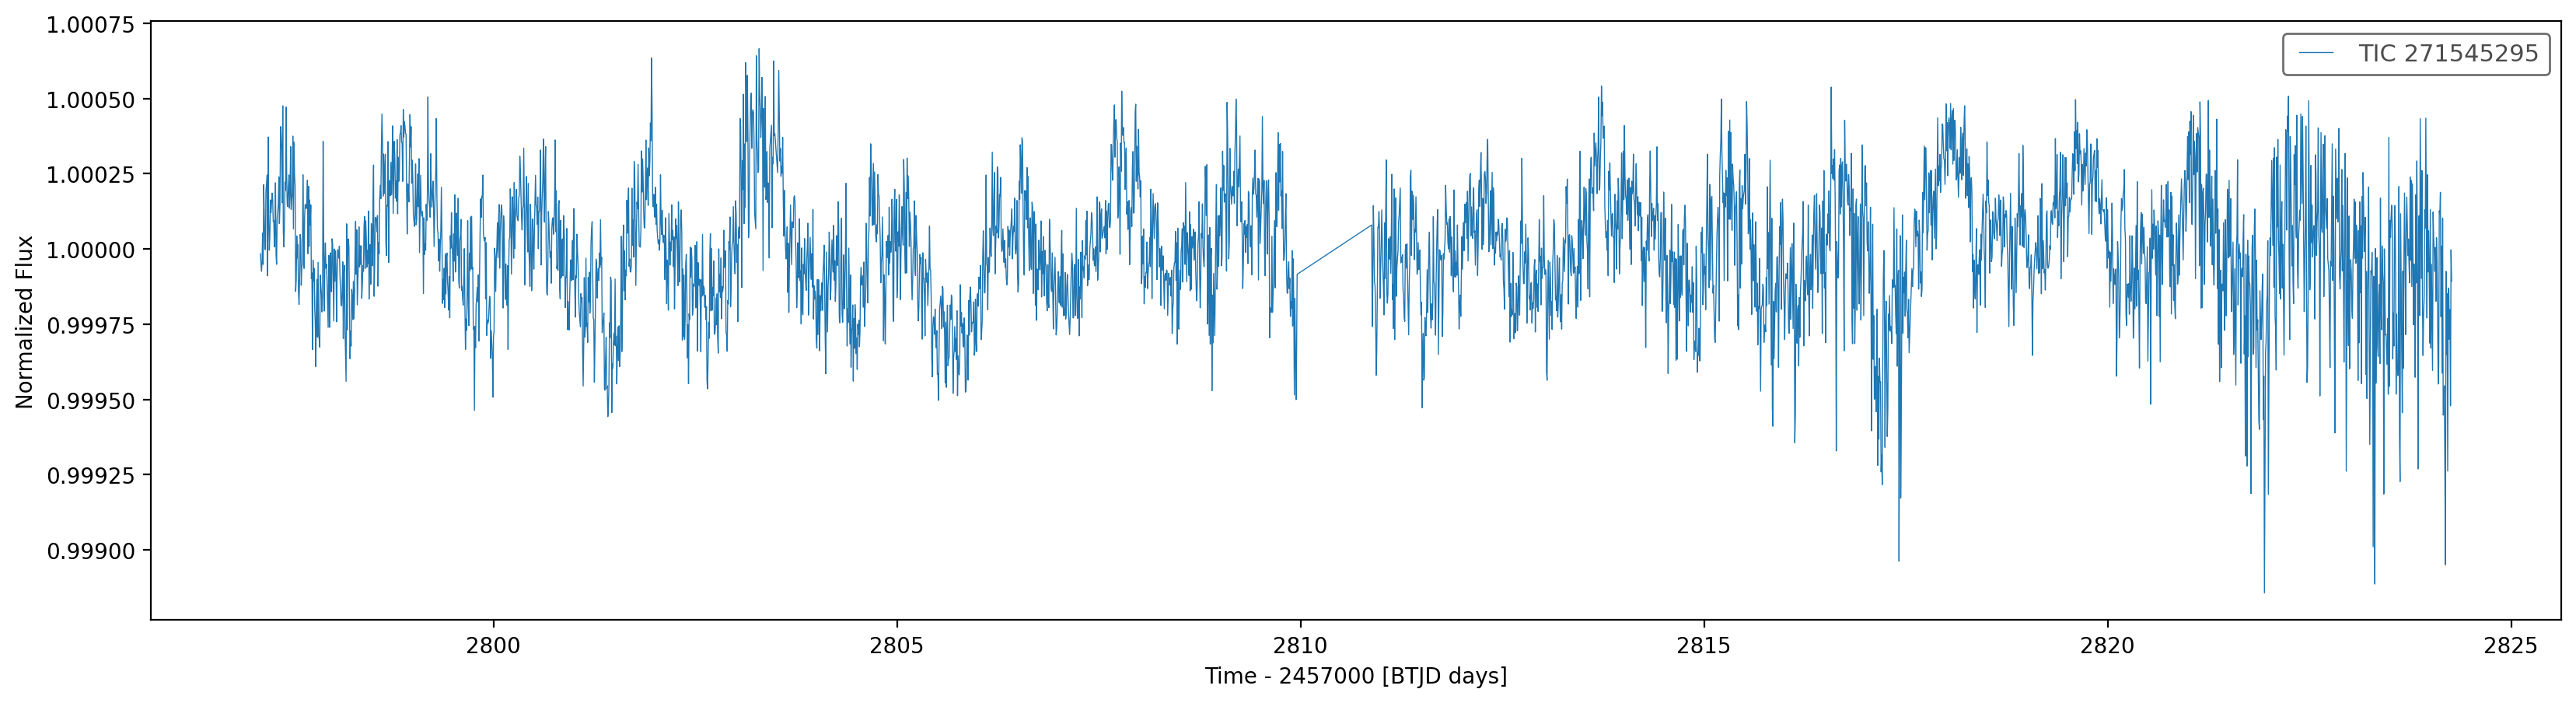

In [34]:
fig, ax = plt.subplots(figsize=(20,5))
lc_2022[1].plot(ax=ax,normalize=True);

In [40]:
pg = lc_2022[1].normalize(unit='ppm').to_periodogram()
period = pg.period_at_max_power
print(period)

1.4756817854920776 d


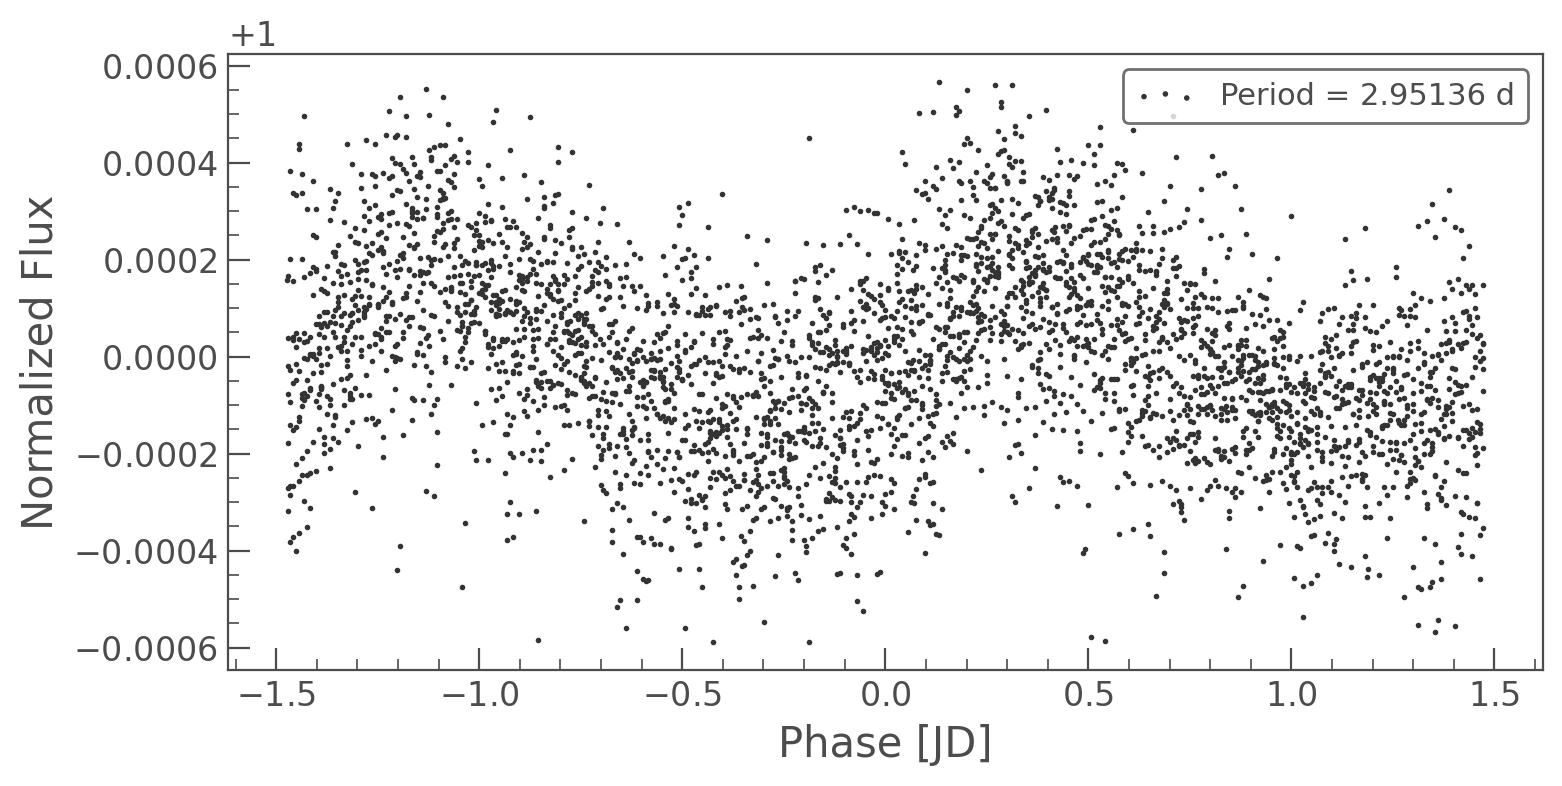

In [81]:
flat_lc = lc_2022[1].flatten(window_length=1001)
clipped_lc = flat_lc.remove_outliers(sigma=3)
folding=2.0*period
clipped_lc.fold(folding).scatter(label=fr'Period = {folding.value:.5f} d');

A = clipped_lc.fold(period=folding) 
t = A.phase.to_value('jd')#+1.5
flux = A.flux


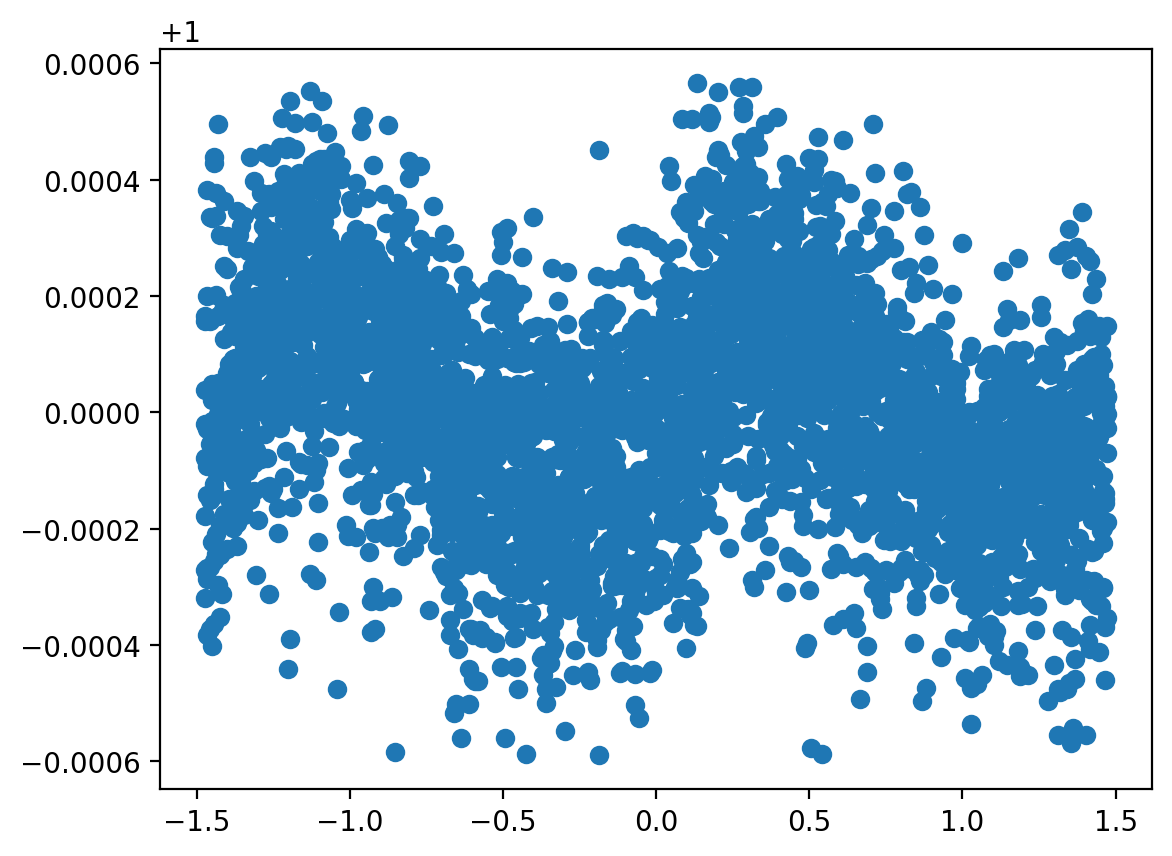

In [82]:
flux = A.flux
plt.scatter(t,flux)
#plt.plot(t, flux_numpy)


In [295]:
with pm.Model() as model:

    # Priors
    contrast1 = pm.Uniform("contrast1", lower=-0.01, upper=0.0, testval=-0.001)
    radius1 = pm.Uniform("radius1", lower=5.0, upper=60.0, testval=20.0)
    lat1 = pm.Uniform("lat1", lower=-90.0, upper=90.0, testval=10)
    lon1 = pm.Uniform("lon1", lower=-180.0, upper=180.0, testval=10)

    contrast2 = pm.Uniform("contrast2", lower=+0.01, upper=0.0, testval=+0.001)
    radius2 = pm.Uniform("radius2", lower=5.0, upper=60.0, testval=20.0)
    lat2 = pm.Uniform("lat2", lower=-90.0, upper=90.0, testval=10)
    lon2 = pm.Uniform("lon2", lower=-180.0, upper=180.0, testval=10)

    # contrast3 = pm.Uniform("contrast3", lower=-0.01, upper=0.0, testval=-0.001)
    # radius3 = pm.Uniform("radius3", lower=5.0, upper=60.0, testval=20.0)
    # lat3 = pm.Uniform("lat3", lower=-90.0, upper=90.0, testval=10)
    # lon3 = pm.Uniform("lon3", lower=-180.0, upper=180.0, testval=10)

    # contrast4 = pm.Uniform("contrast4", lower=+0.01, upper=0.0, testval=+0.001)
    # radius4 = pm.Uniform("radius4", lower=5.0, upper=60.0, testval=20.0)
    # lat4 = pm.Uniform("lat4", lower=-90.0, upper=90.0, testval=10)
    # lon4 = pm.Uniform("lon4", lower=-180.0, upper=180.0, testval=10)

    # Instantiate the map and add the spot
    map = starry.Map(ydeg=15)
    map.inc = inc
    map.spot(contrast=contrast1, radius=radius1, lat=lat1, lon=lon1)
    map.spot(contrast=contrast2, radius=radius2, lat=lat2, lon=lon2)
    #map.spot(contrast=contrast3, radius=radius3, lat=lat3, lon=lon3)
    #map.spot(contrast=contrast4, radius=radius4, lat=lat4, lon=lon4)

    # Compute the flux model
    flux_model = map.flux(theta=360.0 / P * t)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux_numpy)

In [288]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
optimizing logp for variables: [lon2, lat2, radius2, contrast2, lon1, lat1, radius1, contrast1]


message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


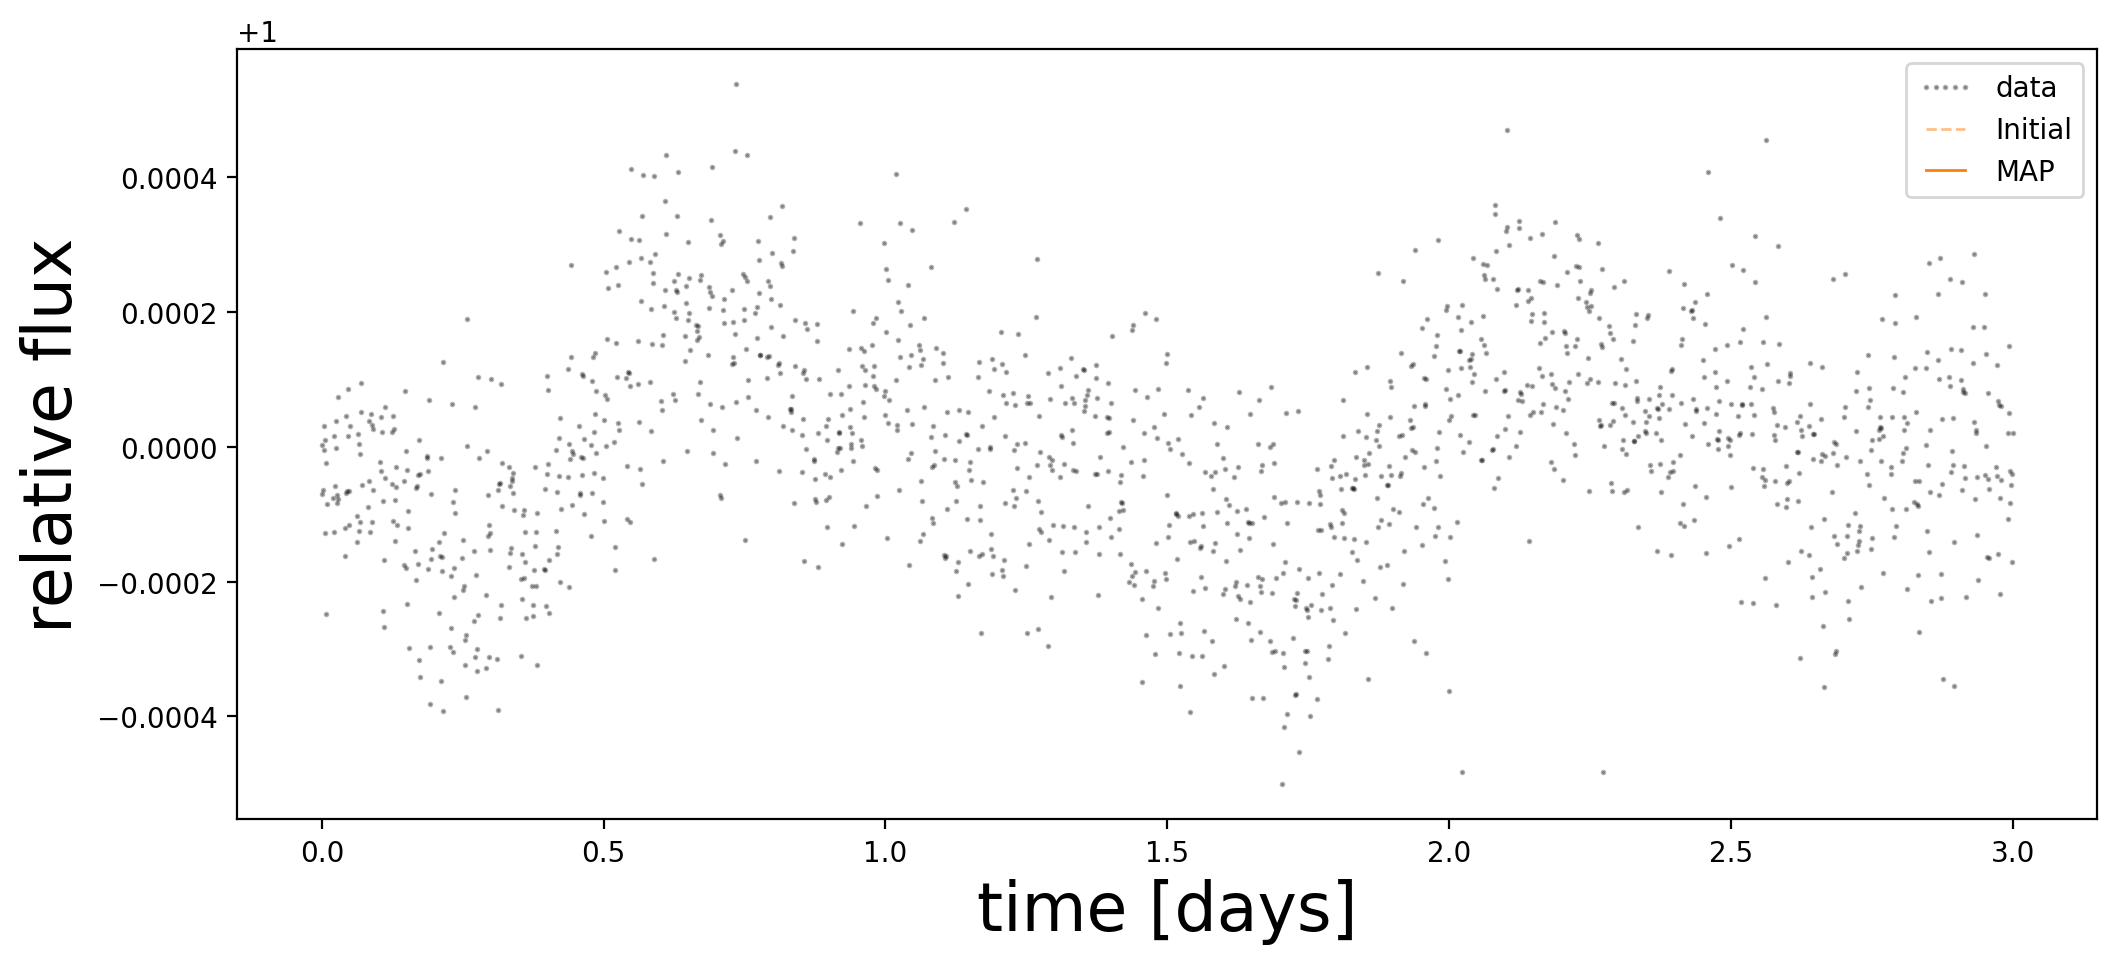

In [207]:
plt.figure(figsize=(12, 5))
plt.plot(t, A.flux, "k.", alpha=0.3, ms=2, label="data")
plt.plot(t, flux_model_guess, "C1--", lw=1, alpha=0.5, label="Initial")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("time [days]", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [24]:
print("{0:12s} {1:10s} {2:10s}".format("", "truth", "map_soln"))
for key in truth1.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth1[key], map_soln[key]))
for key in truth2.keys():
    print("{0:10s} {1:10.5f} {2:10.5f}".format(key, truth2[key], map_soln[key]))    

             truth      map_soln  
contrast1    -0.00100   -0.00323
radius1      15.00000   12.10219
lat1         45.00000   40.11259
lon1         30.00000   -7.56122
contrast2    -0.00010   -0.00224
radius2      45.00000   10.80423
lat2         10.00000   28.73254
lon2        -90.00000  127.20382


In [25]:
with model:
    #trace = pmx.sample(tune=250, draws=500, start=map_soln, chains=4, target_accept=0.9)
    trace = pm.sample(tune=1000, draws=500, start=map_soln, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lon2, lat2, radius2, contrast2, lon1, lat1, radius1, contrast1]
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/matteo-starry-test/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b

In [29]:
var_names = ["contrast1", "radius1", "lat1", "lon1","contrast2", "radius2", "lat2", "lon2"]
display(pm.summary(trace, var_names=var_names))

Got error No model on context stack. trying to find log_likelihood in translation.


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
contrast1  -0.004   0.003   -0.009   -0.000      0.001    0.001       9.0   
radius1    12.796   7.968    5.427   30.629      2.256    1.634      15.0   
lat1        4.091  60.770  -81.427   61.445     28.067   21.231       8.0   
lon1      -20.225  89.455 -159.702  111.654     36.592   29.007       9.0   
contrast2  -0.004   0.003   -0.009   -0.000      0.001    0.001      15.0   
radius2    19.498   8.899    5.498   34.143      2.269    1.636      22.0   
lat2       -0.289  62.005  -83.935   60.465     29.320   22.258       6.0   
lon2       17.854  71.692 -179.937  125.625      3.196   14.057     562.0   

           ess_tail  r_hat  
contrast1      80.0   1.40  
radius1       139.0   1.21  
lat1           33.0   1.76  
lon1           34.0   1.91  
contrast2     376.0   1.20  
radius2       398.0   1.14  
lat2           38.0   1.73  
lon2          244.0   2.08

In [31]:
samples = pm.trace_to_dataframe(trace, varnames=var_names)
corner(samples, truths=[truth[name] for name in var_names]);

KeyError: 'contrast2'